# Freedon of Information Complaints EDA

Hello to my EDA (Exploratory Data Analysis) of the Freedon of Information Complaints from Israel Aug 2024.

Scroll down for the insightful visulizations.


Datasets from:
https://data.gov.il/dataset/hofesh_hameida

In [1]:
# Imports

import re

# EDA packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

#statistical models
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Get Data from APIs
import json
import urllib.request



### Data scraping from DataGov API

Starting by fetching the data through API.

The datasets are from pre and post april 2021, post 2021 has more columns.

In [7]:
# Retrive data from API

# URL for the API request

url_pre_april_2021 = 'https://data.gov.il/api/3/action/datastore_search?resource_id=38fc6470-0440-47bb-9eb2-b32dd9c30aec'
url_post_april_2021 = 'https://data.gov.il/api/3/action/datastore_search?resource_id=b460e022-0f7c-48c6-ba64-ce16e1340056'

# Open the URL and read the response

fileobj_pre = urllib.request.urlopen(url_pre_april_2021)
fileobj_post = urllib.request.urlopen(url_post_april_2021)
r_pre = fileobj_pre.read()
r_post = fileobj_post.read()

# Decode the bytes to a string
r_str_pre = r_pre.decode('utf-8')
r_str_post = r_post.decode('utf-8')

# Parse the JSON data
data_pre = json.loads(r_str_pre)
data_post = json.loads(r_str_post)

# Convert the records (data['result']['records']) into a DataFrame
df_pre_april_2021 = pd.DataFrame(data_pre['result']['records'])
df_post_april_2021 = pd.DataFrame(data_post['result']['records'])


# Display the first few rows of the DataFrame
print(df_pre_april_2021.head())
print(df_post_april_2021.head())


   _id מספר תלונה   ערוץ קבלה תאריך בקשה ראשונית ל מידע נושא  התלונה  \
0    1       2/19  טופס מקוון       2018-11-26T00:00:00  חוסר בהנמקה   
1    2       4/19  טופס מקוון       2018-11-27T00:00:00  אי מתן מענה   
2    3       5/19  טופס מקוון       2018-08-09T00:00:00  אי מתן מענה   
3    4       6/19  טופס מקוון       2018-03-03T00:00:00  אי מתן מענה   
4    5       8/19       דוא"ל       2018-11-18T00:00:00  אי מתן מענה   

      תאריך קבלת תלונה                              שם הנילון  \
0  2019-01-03T00:00:00  משרד העבודה הרווחה והשירותים החברתיים   
1  2019-01-13T00:00:00                 הנהלת בתי הדין הרבניים   
2  2019-01-16T00:00:00                        משרד ראש הממשלה   
3  2019-01-17T00:00:00                             משרד האוצר   
4  2019-01-27T13:25:00                             משרד האוצר   

          תאריך הסגירה תיאור החלטה  
0  2019-03-21T12:15:12       מוצדק  
1  2019-02-17T09:04:41  בלתי מוצדק  
2  2019-03-24T18:04:32       מוצדק  
3  2019-03-11T11:22:06      

In [8]:
## Backup initial data retrived

# Define file paths for saving the CSVs
pre_file_path = '../data/df_pre_april_2021_init.csv'
post_file_path = '../data/df_post_april_2021_init.csv'

# Save the DataFrames to CSV files
df_pre_april_2021.to_csv(pre_file_path, index=False)
df_post_april_2021.to_csv(post_file_path, index=False)

In [6]:
## Fetching backup

df_pre_april_2021 = pd.read_csv(filepath_or_buffer ='../data/df_pre_april_2021_init.csv')
df_post_april_2021 = pd.read_csv(filepath_or_buffer ='../data/df_post_april_2021_init.csv')

## Pre Analysis

### ReNaming columns

In [7]:
# Initial columns names
print("Columns in df_pre_april_2021:\n", df_pre_april_2021.columns)
print("Columns in df_post_april_2021:\n", df_post_april_2021.columns)

Columns in df_pre_april_2021:
 Index(['_id', 'מספר תלונה', 'ערוץ קבלה', 'תאריך בקשה ראשונית ל מידע',
       'נושא  התלונה', 'תאריך קבלת תלונה', 'שם הנילון', 'תאריך הסגירה',
       'תיאור החלטה'],
      dtype='object')
Columns in df_post_april_2021:
 Index(['_id', 'מספר התלונה', 'תאריך הגשת הבקשה למידע', 'תאריך קבלת תלונה',
       'ערוץ קבלת תלונה', 'סוג המתלונן', 'שם המתלונן', 'נושא התלונה',
       'שם הנילון', 'נושא בקשת חופש מידע', 'סטטוס', 'החלטה',
       'תאריך סיום טיפול', 'מספר ימי טיפול'],
      dtype='object')


In [8]:
# Translation dictionary for df_pre_april_2021
pre_translation_dict = {
    '_id': '_id',
    'מספר תלונה': 'Complaint Number',
    'ערוץ קבלה': 'Channel of Receipt',
    'תאריך בקשה ראשונית ל מידע': 'Initial Request Date for Information',
    'נושא  התלונה': 'Complaint Subject',
    'תאריך קבלת תלונה': 'Complaint Receipt Date',
    'שם הנילון': 'Entity Complained Against',
    'תאריך הסגירה': 'Closing Date',
    'תיאור החלטה': 'Decision'
}

# Translation dictionary for df_post_april_2021
post_translation_dict = {
    '_id': '_id',
    'מספר התלונה': 'Complaint Number',  
    'תאריך הגשת הבקשה למידע': 'Initial Request Date for Information',
    'תאריך קבלת תלונה': 'Complaint Receipt Date',
    'ערוץ קבלת תלונה': 'Channel of Receipt', 
    'סוג המתלונן': 'Complainant Type',
    'שם המתלונן': 'Complainant Name',
    'נושא התלונה': 'Complaint Subject', 
    'שם הנילון': 'Entity Complained Against',
    'נושא בקשת חופש מידע': 'Freedom of Information Request Subject',
    'סטטוס': 'Status',
    'החלטה': 'Decision',
    'תאריך סיום טיפול': 'Closing Date', 
    'מספר ימי טיפול': 'Number of Treatment Days'
}

# Rename columns in df_pre_april_2021
df_pre_april_2021.rename(columns=pre_translation_dict, inplace=True)

# Rename columns in df_post_april_2021
df_post_april_2021.rename(columns=post_translation_dict, inplace=True)

# Columns name change validation

print("Columns in df_pre_april_2021:\n", df_pre_april_2021.columns)
print("Columns in df_post_april_2021:\n", df_post_april_2021.columns)


Columns in df_pre_april_2021:
 Index(['_id', 'Complaint Number', 'Channel of Receipt',
       'Initial Request Date for Information', 'Complaint Subject',
       'Complaint Receipt Date', 'Entity Complained Against', 'Closing Date',
       'Decision'],
      dtype='object')
Columns in df_post_april_2021:
 Index(['_id', 'Complaint Number', 'Initial Request Date for Information',
       'Complaint Receipt Date', 'Channel of Receipt', 'Complainant Type',
       'Complainant Name', 'Complaint Subject', 'Entity Complained Against',
       'Freedom of Information Request Subject', 'Status', 'Decision',
       'Closing Date', 'Number of Treatment Days'],
      dtype='object')


### Convert Date Columns to datetime

In [10]:
# Display the first few rows of the DataFrame to identify data Formats
print(df_pre_april_2021[['Complaint Receipt Date', 'Closing Date', 'Initial Request Date for Information']].head())
print(df_post_april_2021[['Complaint Receipt Date', 'Closing Date', 'Initial Request Date for Information']].head())

  Complaint Receipt Date         Closing Date  \
0    2019-01-03T00:00:00  2019-03-21T12:15:12   
1    2019-01-13T00:00:00  2019-02-17T09:04:41   
2    2019-01-16T00:00:00  2019-03-24T18:04:32   
3    2019-01-17T00:00:00  2019-03-11T11:22:06   
4    2019-01-27T13:25:00  2019-06-17T14:27:44   

  Initial Request Date for Information  
0                  2018-11-26T00:00:00  
1                  2018-11-27T00:00:00  
2                  2018-08-09T00:00:00  
3                  2018-03-03T00:00:00  
4                  2018-11-18T00:00:00  
  Complaint Receipt Date Closing Date Initial Request Date for Information
0    2021-09-05 00:00:00   20/06/2021                  2021-01-03 00:00:00
1    2021-05-14 00:00:00   17/11/2021                  2020-10-23 00:00:00
2    2021-05-19 00:00:00   30/08/2021                  2021-04-20 00:00:00
3    2021-08-06 00:00:00   09/06/2021                  2021-06-06 00:00:00
4    2021-04-07 00:00:00   21/07/2021                  2020-02-23 00:00:00


In [11]:
# Convert date columns in df_pre_april_2021 to datetime with explicit format handling

df_pre_april_2021['Complaint Receipt Date'] = pd.to_datetime(df_pre_april_2021['Complaint Receipt Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
df_pre_april_2021['Closing Date'] = pd.to_datetime(df_pre_april_2021['Closing Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
df_pre_april_2021['Initial Request Date for Information'] = pd.to_datetime(df_pre_april_2021['Initial Request Date for Information'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

# Convert date columns in df_post_april_2021 to datetime with explicit format handling

df_post_april_2021['Complaint Receipt Date'] = pd.to_datetime(df_post_april_2021['Complaint Receipt Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
# Handle Closing Date separately, with NaT check
df_post_april_2021['Closing Date'] = df_post_april_2021['Closing Date'].apply(
    lambda x: pd.to_datetime(x, format='%d/%m/%Y', errors='coerce') if pd.notnull(x) and '/' in x else pd.to_datetime(x, errors='coerce')
)
df_post_april_2021['Initial Request Date for Information'] = pd.to_datetime(df_post_april_2021['Initial Request Date for Information'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Verify the Conversion

# Display the first few rows of the DataFrame to verify conversion
print(df_pre_april_2021[['Complaint Receipt Date', 'Closing Date', 'Initial Request Date for Information']].head())
print(df_post_april_2021[['Complaint Receipt Date', 'Closing Date', 'Initial Request Date for Information']].head())

  Complaint Receipt Date        Closing Date  \
0    2019-01-03 00:00:00 2019-03-21 12:15:12   
1    2019-01-13 00:00:00 2019-02-17 09:04:41   
2    2019-01-16 00:00:00 2019-03-24 18:04:32   
3    2019-01-17 00:00:00 2019-03-11 11:22:06   
4    2019-01-27 13:25:00 2019-06-17 14:27:44   

  Initial Request Date for Information  
0                           2018-11-26  
1                           2018-11-27  
2                           2018-08-09  
3                           2018-03-03  
4                           2018-11-18  
  Complaint Receipt Date Closing Date Initial Request Date for Information
0             2021-09-05   2021-06-20                           2021-01-03
1             2021-05-14   2021-11-17                           2020-10-23
2             2021-05-19   2021-08-30                           2021-04-20
3             2021-08-06   2021-06-09                           2021-06-06
4             2021-04-07   2021-07-21                           2020-02-23


In [12]:
# Fill Missing "Complaint Receipt Date" and 'Initial Request Date for Information' in df_pre_april_2021

df_pre_april_2021['Complaint Receipt Date'] = df_pre_april_2021['Complaint Receipt Date'].mask(
    df_pre_april_2021['Complaint Receipt Date'].isnull() & df_pre_april_2021['Initial Request Date for Information'].notnull(),
    df_pre_april_2021['Initial Request Date for Information']
)

df_pre_april_2021['Initial Request Date for Information'] = df_pre_april_2021['Initial Request Date for Information'].fillna(
    df_pre_april_2021['Complaint Receipt Date']
)

In [13]:
# Calculating Number of Treatment Days

df_pre_april_2021['Number of Treatment Days'] = (df_pre_april_2021['Closing Date']-df_pre_april_2021['Complaint Receipt Date']).dt.days

# Check the result
print(df_pre_april_2021[['Complaint Receipt Date', 'Closing Date', 'Number of Treatment Days']].head())


  Complaint Receipt Date        Closing Date  Number of Treatment Days
0    2019-01-03 00:00:00 2019-03-21 12:15:12                        77
1    2019-01-13 00:00:00 2019-02-17 09:04:41                        35
2    2019-01-16 00:00:00 2019-03-24 18:04:32                        67
3    2019-01-17 00:00:00 2019-03-11 11:22:06                        53
4    2019-01-27 13:25:00 2019-06-17 14:27:44                       141


In [14]:
# Due to the fact that Complainant Name in df_post_april_2021 has 500 null values from 641 entries, so it's ambiguous and removed. # Also considering privacy issue it is best removed

number_of_null_names = df_post_april_2021['Complainant Name'].isnull().sum()
total_entries = df_post_april_2021['_id'].count()

print(f"Number of null values in 'Complainant Name': {number_of_null_names}")
print(f"Total number of entries: {total_entries}")

# Remove the Complainant Name column
df_post_april_2021.drop(columns=['Complainant Name'], inplace=True)

# Verify the column removal
print(df_post_april_2021.columns)

Number of null values in 'Complainant Name': 502
Total number of entries: 642
Index(['_id', 'Complaint Number', 'Initial Request Date for Information',
       'Complaint Receipt Date', 'Channel of Receipt', 'Complainant Type',
       'Complaint Subject', 'Entity Complained Against',
       'Freedom of Information Request Subject', 'Status', 'Decision',
       'Closing Date', 'Number of Treatment Days'],
      dtype='object')


In [15]:
# Replace the null values in the 'Complaint Subject' column of df_pre_april_2021 with 'Unknown'
df_pre_april_2021['Complaint Subject'] = df_pre_april_2021['Complaint Subject'].fillna('Unknown')

# Verify the change
print(df_pre_april_2021['Complaint Subject'].head())

# Replace the null values in the 'Freedom of Information Request Subject' column of df_post_april_2021 with 'Unknown'
df_post_april_2021['Freedom of Information Request Subject'] = df_post_april_2021['Freedom of Information Request Subject'].fillna('Unknown')

# Verify the change
print(df_post_april_2021['Freedom of Information Request Subject'].head())


0    חוסר בהנמקה
1    אי מתן מענה
2    אי מתן מענה
3    אי מתן מענה
4    אי מתן מענה
Name: Complaint Subject, dtype: object
0    דוח מוניטור בנושא יישום דו"ח מבקר שנתי )2010 )...
1                        נתונים על מחלקות פסיכיאטריות 
2                                      פרמיות סטודנטים
3                           אי מתן מענה סמוכין 273664 
4                  דישון KCL אורגני לשנה בקרקעות ישראל
Name: Freedom of Information Request Subject, dtype: object


In [16]:
# Translation mapping for "Complaint Subject"
complaint_subject_translation_dict = {
    'אי מתן מענה': 'No Response',
    'חוסר בהנמקה': 'Lack of Justification',
    'Unknown': 'Unknown',
    'אגרות': 'Fees',
    'דין וחשבון שנתי': 'Annual Report',
    'הנחיות מנהליות': 'Administrative Guidelines',
    'מידע סביבתי': 'Environmental Information',
    'פרסום הנחיות מנהליות': 'Publication of Administrative Guidelines'
}

# Apply the translation mapping to the "Complaint Subject" column in df_pre_april_2021
df_pre_april_2021['Complaint Subject'] = df_pre_april_2021['Complaint Subject'].map(complaint_subject_translation_dict)

# Apply the translation mapping to the "Complaint Subject" column in df_post_april_2021
df_post_april_2021['Complaint Subject'] = df_post_april_2021['Complaint Subject'].map(complaint_subject_translation_dict)

# Verify the translations by checking the unique values in each column
unique_complaint_subjects_pre = df_pre_april_2021['Complaint Subject'].unique()
unique_complaint_subjects_post = df_post_april_2021['Complaint Subject'].unique()

unique_complaint_subjects_pre, unique_complaint_subjects_post

(array(['Lack of Justification', 'No Response',
        'Administrative Guidelines', 'Unknown',
        'Environmental Information', 'Annual Report', 'Fees'], dtype=object),
 array(['No Response', 'Lack of Justification', 'Fees',
        'Publication of Administrative Guidelines',
        'Environmental Information', 'Annual Report'], dtype=object))

In [17]:
# Translation mapping for 'Channel of Receipt'
# Dictionary to unify the values
channel_of_receipt_dict = {
    'טופס מקוון': 'Online Form',
    'דואר אלקטרוני': 'Email',
    'דוא"ל': 'Email',
    'פקס': 'Fax',
    'טלפון': 'Phone'
}

# Apply the dictionary to unify the "Channel of Receipt" column in df_pre_april_2021
df_pre_april_2021['Channel of Receipt'] = df_pre_april_2021['Channel of Receipt'].map(channel_of_receipt_dict)

# Apply the dictionary to unify the "Channel of Receipt" column in df_post_april_2021
df_post_april_2021['Channel of Receipt'] = df_post_april_2021['Channel of Receipt'].map(channel_of_receipt_dict)

# Validation
print(df_post_april_2021['Channel of Receipt'].value_counts())
print(df_pre_april_2021['Channel of Receipt'].value_counts())


Channel of Receipt
Online Form    587
Email           55
Name: count, dtype: int64
Channel of Receipt
Online Form    342
Email          100
Fax              1
Phone            1
Name: count, dtype: int64


In [18]:
# Translation mapping for pre "Decision" and post "Decision" columns
decision_translation_dict = {
    'מוצדק': 'Justified',
    'בלתי מוצדק': 'Unjustified',
    'הטיפול הופסק': 'Treatment Discontinued',
    'מוצדק חלקית': 'Partially Justified',
    '': 'Not Concluded',  
    'סיום טיפול': 'Treatment Completed'
}

# Apply the translation mapping to the "Decision Description" column in df_pre_april_2021
df_pre_april_2021['Decision'] = df_pre_april_2021['Decision'].map(decision_translation_dict)

# Apply the translation mapping to the "Decision" column in df_post_april_2021
df_post_april_2021['Decision'] = df_post_april_2021['Decision'].map(decision_translation_dict)

# Verify the translations by checking the unique values in each column
unique_decisions_pre = df_pre_april_2021['Decision'].unique()
unique_decisions_post = df_post_april_2021['Decision'].unique()

unique_decisions_pre, unique_decisions_post

(array(['Justified', 'Unjustified', 'Treatment Discontinued',
        'Partially Justified'], dtype=object),
 array(['Justified', 'Unjustified', 'Partially Justified', nan,
        'Treatment Completed'], dtype=object))

In [19]:
# Translation mapping for "Status" column
status_translation_dict = {
    'סיום טיפול': 'Treatment Completed',
    'בטיפול': 'In Treatment',
    '': 'No Status',
    'נשוא החלטת משרד הבריאות מה-13.11.22"': 'Subject to Ministry of Health Decision as of 13.11.22',
    'Unknown': "Unknown",
}

# Apply the translation mapping to the "Status" column in df_post_april_2021
df_post_april_2021['Status'] = df_post_april_2021['Status'].map(status_translation_dict)

# Null handeling
df_post_april_2021['Status'] = df_post_april_2021['Status'].fillna('Unknown')

# Verify the translations by checking the unique values in the "Status" column
unique_status_post = df_post_april_2021['Status'].unique()

unique_status_post

array(['Treatment Completed', 'Unknown', 'In Treatment'], dtype=object)

In [20]:
### Add a Status column to the df_pre_april_2021 DataFrame based on whether there is a Closing Date

# Create the 'Status' column based on the presence of 'Closing Date'
df_pre_april_2021['Status'] = df_pre_april_2021['Closing Date'].apply(
    lambda x: 'Treatment Completed' if pd.notnull(x) else 'In Treatment'
)

# Verify the new 'Status' column
df_pre_april_2021[['Closing Date', 'Status']].head()


,Closing Date,Status
0,2019-03-21 12:15:12,Treatment Completed
1,2019-02-17 09:04:41,Treatment Completed
2,2019-03-24 18:04:32,Treatment Completed
3,2019-03-11 11:22:06,Treatment Completed
4,2019-06-17 14:27:44,Treatment Completed


In [21]:
### Handeling duplication and error in the values of Entity Complained Against
print('Entities from df_pre_april_2021\n' )
print(df_pre_april_2021['Entity Complained Against'].unique())
print(df_pre_april_2021['Entity Complained Against'].value_counts())
print('Entities from df_post_april_2021\n')
print(df_post_april_2021['Entity Complained Against'].unique())
print(df_post_april_2021['Entity Complained Against'].value_counts())

Entities from df_pre_april_2021

['משרד העבודה הרווחה והשירותים החברתיים' 'הנהלת בתי הדין הרבניים'
 'משרד ראש הממשלה' 'משרד האוצר' 'משרד הבריאות'
 'משרד התחבורה והבטיחות בדרכים' 'רשות המסים בישראל' 'רשות האכיפה והגבייה'
 'משרד החקלאות ופיתוח הכפר' 'המשרד לביטחון פנים' 'הנהלת בתי המשפט'
 'משרד החינוך' 'משרד הביטחון' 'עיריית טבריה' 'רשות מקרקעי ישראל'
 'רשות המים והביוב' 'רשות האוכלוסין וההגירה' 'המשרד לביטחון הפנים'
 'המשרד להגנת הסביבה' 'משרד המשפטים' 'האפוטרופוס הכללי והכונס הרשמי'
 'צה"ל' 'צבא הגנה לישראל' 'משטרת ישראל' 'משרד העלייה והקליטה'
 'המשרד לנושאים אסטרטגיים והסברה' 'המשרד לשוויון חברתי'
 'רשות החברות הממשלתיות' 'משרד הפנים' 'מנהל אזרחי אזור יהודה ושומרון'
 'רשות התחרות' 'הרשות להסדרת התיישבות הבדואים בנגב'
 'רשות שוק ההון, הביטוח והחיסכון' 'הרבנות הראשית לישראל'
 'משרד הבינוי והשיכון' 'משרד התקשורת' 'נציבות שירות המדינה'
 'מרכז רפואי פוריה' 'בית חולים וולפסון' 'בית חולים איכילוב'
 'שירות בתי הסוהר' 'מתאם פעולות הממשלה בשטחים (מתפ"ש)' 'המשרד לשירותי דת'
 'משרד התיירות' 'משרד

In [22]:
# Function to clean and standardize entity names
def clean_entity_name(entity_name):
    # Remove leading/trailing whitespaces
    entity_name = entity_name.strip()
    # Replace special characters or unify them
    entity_name = re.sub(r'[^\w\s]', '', entity_name)
    return entity_name

# Apply cleaning function to the 'Entity Complained Against' column
df_pre_april_2021['Entity Complained Against'] = df_pre_april_2021['Entity Complained Against'].apply(clean_entity_name)
df_post_april_2021['Entity Complained Against'] = df_post_april_2021['Entity Complained Against'].apply(clean_entity_name)

# Check for duplicates by counting the cleaned names
duplicate_check_pre = df_pre_april_2021['Entity Complained Against'].value_counts()
duplicate_check_post = df_post_april_2021['Entity Complained Against'].value_counts()
print(duplicate_check_pre, duplicate_check_post)

Entity Complained Against
משרד הבריאות                             48
משרד החינוך                              37
משטרת ישראל                              32
המשרד להגנת הסביבה                       26
צהל                                      25
משרד ראש הממשלה                          21
משרד התחבורה והבטיחות בדרכים             21
משרד העבודה הרווחה והשירותים החברתיים    18
משרד החקלאות ופיתוח הכפר                 16
משרד האוצר                               15
נציבות שירות המדינה                      14
רשות מקרקעי ישראל                        13
משרד הפנים                               13
משרד המשפטים                             12
רשות האוכלוסין וההגירה                   11
משרד הביטחון                              9
מנהל אזרחי אזור יהודה ושומרון             8
המשרד לביטחון הפנים                       8
צבא הגנה לישראל                           7
משרד הבינוי והשיכון                       6
הנהלת בתי הדין הרבניים                    6
רשות שוק ההון הביטוח והחיסכון             6
מתאם פ

### Null handling

In [23]:
# Check for missing values
missing_values = df_post_april_2021.isnull().sum()
print("Missing values in df_post_april_2021 each column:\n", missing_values)
# Check for missing values
missing_values = df_pre_april_2021.isnull().sum()
print("Missing values in df_pre_april_2021 each column:\n", missing_values)

Missing values in df_post_april_2021 each column:
 _id                                        0
Complaint Number                           0
Initial Request Date for Information       0
Complaint Receipt Date                     0
Channel of Receipt                         0
Complainant Type                           0
Complaint Subject                          0
Entity Complained Against                  0
Freedom of Information Request Subject     0
Status                                     0
Decision                                  23
Closing Date                              23
Number of Treatment Days                   0
dtype: int64
Missing values in df_pre_april_2021 each column:
 _id                                     0
Complaint Number                        0
Channel of Receipt                      0
Initial Request Date for Information    0
Complaint Subject                       0
Complaint Receipt Date                  0
Entity Complained Against               0
Closing

In [24]:
# Display rows with any missing values in df_pre_april_2021
rows_with_nulls_pre = df_pre_april_2021[df_pre_april_2021.isnull().any(axis=1)]

# Display rows with any missing values in df_post_april_2021
rows_with_nulls_post = df_post_april_2021[df_post_april_2021.isnull().any(axis=1)]

rows_with_nulls_pre, rows_with_nulls_post


(Empty DataFrame
 Columns: [_id, Complaint Number, Channel of Receipt, Initial Request Date for Information, Complaint Subject, Complaint Receipt Date, Entity Complained Against, Closing Date, Decision, Number of Treatment Days, Status]
 Index: [],
      _id Complaint Number Initial Request Date for Information  \
 18    19           142/24                           2023-09-13   
 141  142           250/24                           2023-11-19   
 149  150           266/24                           2024-05-16   
 155  156           132/24                           2024-03-20   
 163  164           257/24                           2024-02-15   
 296  297           255/24                           2024-03-25   
 306  307           259/24                           2024-03-13   
 319  320           234/24                           2023-07-06   
 340  341           248/24                           2024-02-20   
 342  343           268/24                           2024-05-16   
 349  350     

In [25]:
## Backup

# Define file paths for saving the CSVs
pre_file_path = '../data/df_pre_april_2021.csv'
post_file_path = '../data/df_post_april_2021.csv'

# Save the DataFrames to CSV files
df_pre_april_2021.to_csv(pre_file_path, index=False)
df_post_april_2021.to_csv(post_file_path, index=False)

#### Merge the dataframes

In [26]:
# Concatenate the two DataFrames.

# Determine the maximum _id in df_pre_april_2021
max_id_pre = df_pre_april_2021['_id'].max()

# Increment the _id in df_post_april_2021
df_post_april_2021['_id'] += max_id_pre

# Concatenate the DataFrames
df_combined = pd.concat([df_pre_april_2021, df_post_april_2021], ignore_index=True)

# Display the first few rows of the combined DataFrame to verify
print(df_combined.head())
print(df_combined.tail())

# Save the combined DataFrame to a CSV file
df_combined.to_csv('../data/combined_data.csv', index=False)

print("CSV file has been saved successfully.")

   _id Complaint Number Channel of Receipt  \
0    1             2/19        Online Form   
1    2             4/19        Online Form   
2    3             5/19        Online Form   
3    4             6/19        Online Form   
4    5             8/19              Email   

  Initial Request Date for Information      Complaint Subject  \
0                           2018-11-26  Lack of Justification   
1                           2018-11-27            No Response   
2                           2018-08-09            No Response   
3                           2018-03-03            No Response   
4                           2018-11-18            No Response   

  Complaint Receipt Date              Entity Complained Against  \
0    2019-01-03 00:00:00  משרד העבודה הרווחה והשירותים החברתיים   
1    2019-01-13 00:00:00                 הנהלת בתי הדין הרבניים   
2    2019-01-16 00:00:00                        משרד ראש הממשלה   
3    2019-01-17 00:00:00                             משרד האוצר 

In [27]:
## Fetching backup for df_combined_data

df_combined_data = pd.read_csv(filepath_or_buffer ='../data/combined_data.csv')

In [28]:
# Mini EDA on the df_combined

print(df_combined.dtypes)

print(df_combined.columns)

# Summary statistics for numeric columns
print("\nSummary Statistics (Numeric Columns):")
print(df_combined.describe())

# Summary statistics for categorical columns
print("\nSummary Statistics (Categorical Columns):")
print(df_combined.describe(include='object'))

# Value counts for each column
print("\nValue Counts for Each Column:")
for column in df_combined.columns:
    print(f"\nValue counts for {column}:")
    print(df_combined[column].value_counts())


_id                                                int64
Complaint Number                                  object
Channel of Receipt                                object
Initial Request Date for Information      datetime64[ns]
Complaint Subject                                 object
Complaint Receipt Date                    datetime64[ns]
Entity Complained Against                         object
Closing Date                              datetime64[ns]
Decision                                          object
Number of Treatment Days                          object
Status                                            object
Complainant Type                                  object
Freedom of Information Request Subject            object
dtype: object
Index(['_id', 'Complaint Number', 'Channel of Receipt',
       'Initial Request Date for Information', 'Complaint Subject',
       'Complaint Receipt Date', 'Entity Complained Against', 'Closing Date',
       'Decision', 'Number of Treatment Day

In [29]:
# Check for missing values in df_combined
missing_values = df_combined.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 _id                                         0
Complaint Number                            0
Channel of Receipt                          0
Initial Request Date for Information        0
Complaint Subject                           0
Complaint Receipt Date                      0
Entity Complained Against                   0
Closing Date                               23
Decision                                   23
Number of Treatment Days                    0
Status                                      0
Complainant Type                          444
Freedom of Information Request Subject    444
dtype: int64


The 23 'Closing Date' and 'Decision' null values are due to the them being In Treatment   
The 444 'Complainant Type', 'Freedom of Information Request Subject' are present only in post_april_2021 df                          

In [30]:
# Pereperation for visualization

# Extract year from 'Complaint Receipt Date'
df_combined['Complaint Receipt Year'] = df_combined['Complaint Receipt Date'].dt.year
# Print to validate
print("Unique years in 'Complaint Receipt Year':", df_combined['Complaint Receipt Year'].unique())

# Extract month from 'Complaint Receipt Date'
df_combined['Complaint Receipt Month'] = df_combined['Complaint Receipt Date'].dt.month
# Print to validate
print("Unique months in 'Complaint Receipt Month':", df_combined['Complaint Receipt Month'].unique())

# Assuming 'Number of Treatment Days' column exists and needs to be converted to numeric
df_combined['Number of Treatment Days'] = pd.to_numeric(df_combined['Number of Treatment Days'], errors='coerce')
# Print to validate conversion
print("First few values in 'Number of Treatment Days':\n", df_combined['Number of Treatment Days'].head())

# Calculate the difference in days
df_combined['Initial Response Days'] = pd.to_numeric((df_combined['Complaint Receipt Date'] - df_combined['Initial Request Date for Information']).dt.days)
# Print to validate calculation
print("First few values in 'Initial Response Days' (before fixing negatives):\n", df_combined['Initial Response Days'].head())

# Convert any negative values to zero
df_combined['Initial Response Days'] = df_combined['Initial Response Days'].apply(lambda x: max(x, 0))
# Print to validate conversion of negatives to zero
print("First few values in 'Initial Response Days' (after fixing negatives):\n", df_combined['Initial Response Days'].head())

# Display the first few rows to verify
print(df_combined[['Initial Request Date for Information', 'Complaint Receipt Date', 'Initial Response Days']].head())

# Fill missing values in 'Freedom of Information Request Subject' and 'Complainant Type' with 'Unspecified'
df_combined = df_combined.assign(
    **{
        'Freedom of Information Request Subject': df_combined['Freedom of Information Request Subject'].fillna('Unspecified'),
        'Complainant Type': df_combined['Complainant Type'].fillna('Unspecified')
    }
)
# Print to validate filling missing values
print("Unique values in 'Freedom of Information Request Subject':", df_combined['Freedom of Information Request Subject'].unique())
print("Unique values in 'Complainant Type':", df_combined['Complainant Type'].unique())

Unique years in 'Complaint Receipt Year': [2019 2020 2021 2022 2023 2024]
Unique months in 'Complaint Receipt Month': [ 1  2  3  4  5  6  7  8  9 10 11 12]
First few values in 'Number of Treatment Days':
 0     77.0
1     35.0
2     67.0
3     53.0
4    141.0
Name: Number of Treatment Days, dtype: float64
First few values in 'Initial Response Days' (before fixing negatives):
 0     38
1     47
2    160
3    320
4     70
Name: Initial Response Days, dtype: int64
First few values in 'Initial Response Days' (after fixing negatives):
 0     38
1     47
2    160
3    320
4     70
Name: Initial Response Days, dtype: int64
  Initial Request Date for Information Complaint Receipt Date  \
0                           2018-11-26    2019-01-03 00:00:00   
1                           2018-11-27    2019-01-13 00:00:00   
2                           2018-08-09    2019-01-16 00:00:00   
3                           2018-03-03    2019-01-17 00:00:00   
4                           2018-11-18    2019-01-2

In [31]:
# Identify the row with the missing value in 'Number of Treatment Days'
missing_treatment_days_row = df_combined[df_combined['Number of Treatment Days'].isnull()]

missing_treatment_days_row

,_id,Complaint Number,Channel of Receipt,Initial Request Date for Information,Complaint Subject,Complaint Receipt Date,Entity Complained Against,Closing Date,Decision,Number of Treatment Days,Status,Complainant Type,Freedom of Information Request Subject,Complaint Receipt Year,Complaint Receipt Month,Initial Response Days
1066,1067,43/23,Online Form,2022-08-07,No Response,2023-08-02,משרד הבריאות,NaT,Treatment Completed,NaN,Unknown,אזרח,לא נשלח הדוח,2023,8,360


In [32]:
# Binary encoding for the 'Decision' column
df_combined['Justified'] = df_combined['Decision'].apply(lambda x: 1 if x == 'Justified' else 0)

In [33]:
# EDA Entity Complained Against

print(df_combined['Entity Complained Against'].unique( ))
print(df_combined['Entity Complained Against'].value_counts())

merge_dict = {
    'משרד העבודה הרווחה והשירותים החברתיים': 'משרד הרווחה והשירותים החברתיים',
    'משרד התחבורה והבטיחות בדרכים ': 'משרד התחבורה והבטיחות בדרכים',
    'צהל': 'צבא הגנה לישראל',
    'צה"ל': 'צבא הגנה לישראל',
    '"צהל': 'צבא הגנה לישראל',
    'הרשות לאכיפה במקרקעין  משרד האוצר': 'רשות האכיפה והגבייה',
    'מתאם פעולות הממשלה בשטחים מתפש': 'מתאם פעולות הממשלה בשטחים (מתפש)',
    'המרכז לבריאות הנפש שער מנשה': 'המרכז לבריאות הנפש שער מנשה',
    'משרד המשפטים ': 'משרד המשפטים',
    'מינהל התכנון ': 'מינהל התכנון',
    'משרד החינוך ': 'משרד החינוך',
    'מרכז רפואי שיבא ': 'מרכז רפואי שיבא',
    'הרבנות הראשית לישראל': 'הרבנות הראשית לישראל',
    'משרד העבודה': 'משרד העבודה הרווחה והשירותים החברתיים',
    'משרד הבינוי והשיכון': 'משרד הבינוי והשיכון',
    'משרד התרבות והספורט': 'משרד התרבות והספורט',
    'משרד החוץ': 'משרד החוץ',
    'משרד התיירות': 'משרד התיירות',
    'רשות מקרקעי ישראל': 'רשות מקרקעי ישראל',
    'רשות המסים בישראל': 'רשות המסים בישראל',
    'שירות בתי הסוהר': 'שירות בתי הסוהר',
    'שב"ס': 'שירות בתי הסוהר',
    'מינהל התכנון': 'מינהל התכנון',
    'הרשות להגנת הצרכן ולסחר הוגן': 'הרשות להגנת הצרכן ולסחר הוגן',
    'משרד הכלכלה': 'משרד הכלכלה',
    'רשות האוכלוסין וההגירה': 'רשות האוכלוסין וההגירה',
    'רשות החשמל': 'רשות החשמל',
    'משרד הרווחה והשירותים החברתיים': 'משרד העבודה הרווחה והשירותים החברתיים',
    'הנהלת בתי המשפט': 'הנהלת בתי המשפט',
    'האפוטרופוס הכללי והכונס הרשמי': 'האפוטרופוס הכללי והכונס הרשמי',
    'המשרד לשוויון חברתי': 'המשרד לשוויון חברתי',
    'הרשות הארצית לכבאות והצלה': 'הרשות הארצית לכבאות והצלה',
    'משרד הבריאות': 'משרד הבריאות',
    'משרד הביטחון': 'משרד הביטחון',
    'משרד הפנים': 'משרד הפנים',
    'המשרד להגנת הסביבה': 'המשרד להגנת הסביבה',
    'רשות החברות הממשלתיות': 'רשות החברות הממשלתיות',
    'מרכז בריאות הנפש באר שבע': 'מרכז בריאות הנפש באר שבע',
    'מרכז בריאות הנפש מזור': 'מרכז בריאות הנפש מזור',
    'המרכז הרפואי לבריאות הנפש מעלה הכרמל': 'המרכז הרפואי לבריאות הנפש מעלה הכרמל',
    'משרד התקשורת': 'משרד התקשורת',
    'משרד התחבורה והבטיחות בדרכים': 'משרד התחבורה והבטיחות בדרכים',
    'משרד המשפטים': 'משרד המשפטים',
    'משרד החינוך': 'משרד החינוך',
    'משרד החקלאות ופיתוח הכפר': 'משרד החקלאות ופיתוח הכפר',
    'הנהלת בתי הדין הרבניים': 'הנהלת בתי הדין הרבניים',
    'משרד ראש הממשלה': 'משרד ראש הממשלה',
    'רשות התחרות': 'רשות התחרות',
    'המשרד לשירותי דת': 'המשרד לשירותי דת',
    'רשות המים והביוב': 'רשות המים והביוב',
    'משרד הבינוי והשיכון': 'משרד הבינוי והשיכון',
    'מרכז בריאות הנפש מזור': 'מרכז בריאות הנפש מזור',
    'מרכז בריאות הנפש באר שבע': 'מרכז בריאות הנפש באר שבע',
    'הרבנות הראשית לישראל': 'הרבנות הראשית לישראל',
    'בית חולים איכילוב': 'בית חולים איכילוב',
    'בית חולים וולפסון': 'בית חולים וולפסון',
    'בית חולים רמבם': 'בית חולים רמבם',
    'מרכז רפואי שיבא': 'מרכז רפואי שיבא',
    'בית חולים אסף הרופא': 'בית חולים אסף הרופא',
    'מרכז בריאות הנפש מזור': 'מרכז בריאות הנפש מזור',
    'המרכז הירושלמי לבריאות הנפש': 'המרכז הירושלמי לבריאות הנפש',
    'מרכז בריאות הנפש באר שבע': 'מרכז בריאות הנפש באר שבע',
    'המרכז לבריאות הנפש באריעקב נסציונה מבן (שבס)': 'המרכז לבריאות הנפש באר-יעקב נס-ציונה מבן (שב"ס)',
    'המרכז לבריאות הנפש באריעקב נסציונה מבן שבס': 'המרכז לבריאות הנפש באר-יעקב נס-ציונה מבן (שב"ס)',
    'המרכז לבריאות הנפש באר יעקב נסציונה מבן שבס': 'המרכז לבריאות הנפש באר-יעקב נס-ציונה מבן (שב"ס)',
    'המרכז לבריאות הנפש שער מנשה': 'המרכז לבריאות הנפש שער מנשה',
    'משרד הבינוי והשיכון': 'משרד הבינוי והשיכון',
    'משרד הפנים': 'משרד הפנים',
    'רשות מקרקעי ישראל': 'רשות מקרקעי ישראל',
    'משרד הבריאות': 'משרד הבריאות',
    'משרד העבודה': 'משרד העבודה הרווחה והשירותים החברתיים',
    'רשות התחרות': 'רשות התחרות',
    'המשרד לביטחון לאומי': 'המשרד לביטחון פנים'
}

# Apply the mapping
df_combined['Entity Complained Against'] = df_combined['Entity Complained Against'].replace(merge_dict)

# Check the updated value counts
print(df_combined['Entity Complained Against'].value_counts())

['משרד העבודה הרווחה והשירותים החברתיים' 'הנהלת בתי הדין הרבניים'
 'משרד ראש הממשלה' 'משרד האוצר' 'משרד הבריאות'
 'משרד התחבורה והבטיחות בדרכים' 'רשות המסים בישראל' 'רשות האכיפה והגבייה'
 'משרד החקלאות ופיתוח הכפר' 'המשרד לביטחון פנים' 'הנהלת בתי המשפט'
 'משרד החינוך' 'משרד הביטחון' 'עיריית טבריה' 'רשות מקרקעי ישראל'
 'רשות המים והביוב' 'רשות האוכלוסין וההגירה' 'המשרד לביטחון הפנים'
 'המשרד להגנת הסביבה' 'משרד המשפטים' 'האפוטרופוס הכללי והכונס הרשמי' 'צהל'
 'צבא הגנה לישראל' 'משטרת ישראל' 'משרד העלייה והקליטה'
 'המשרד לנושאים אסטרטגיים והסברה' 'המשרד לשוויון חברתי'
 'רשות החברות הממשלתיות' 'משרד הפנים' 'מנהל אזרחי אזור יהודה ושומרון'
 'רשות התחרות' 'הרשות להסדרת התיישבות הבדואים בנגב'
 'רשות שוק ההון הביטוח והחיסכון' 'הרבנות הראשית לישראל'
 'משרד הבינוי והשיכון' 'משרד התקשורת' 'נציבות שירות המדינה'
 'מרכז רפואי פוריה' 'בית חולים וולפסון' 'בית חולים איכילוב'
 'שירות בתי הסוהר' 'מתאם פעולות הממשלה בשטחים מתפש' 'המשרד לשירותי דת'
 'משרד התיירות' 'משרדי ממשלה שונים בתלונות רוחביות' 'משרד ה

In [35]:
# Save Backup the combined DataFrame to a CSV file
df_combined.to_csv('../data/combined_data_ready.csv', index=False)

print("CSV file has been saved successfully.")

CSV file has been saved successfully.


## Visualization

### Complaints Viz

#### Count Plot for Complaints by Year

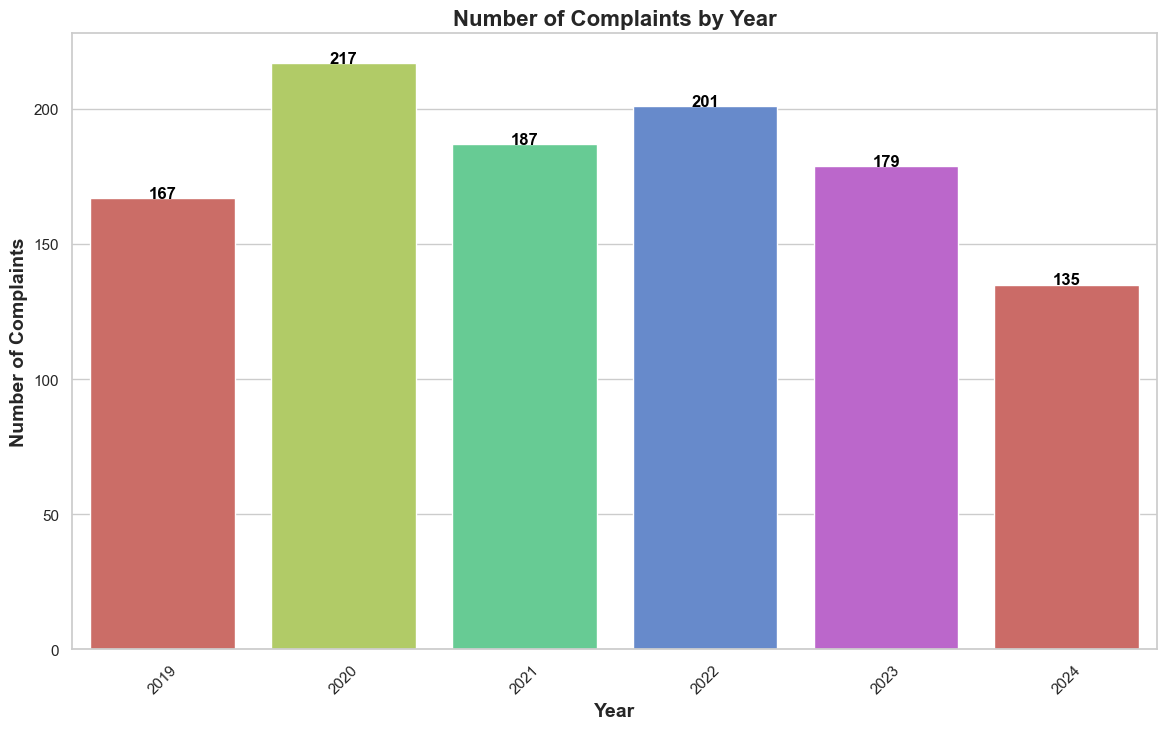

In [102]:
# Plot Complaints by Year

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(x='Complaint Receipt Year', hue='Complaint Receipt Year', data=df_combined, palette='hls', legend=False)

# Add title and labels with professional formatting
plt.title('Number of Complaints by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

# Add the exact value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=12, color='black', fontweight='bold')

# Show the plot
plt.show()

This bar chart displays the number of complaints by year from 2019 to 2024, showing an initial increase in complaints from 2019 to 2020, peaking in 2020 with 217 complaints. Afterward, there is a slight decline, with 2023 seeing a modest recovery before dropping again in 2024. The initial surge in complaints in 2020 could be linked to specific external factors or heightened awareness, while the subsequent decline might indicate improved processes or resolution mechanisms. However, the drop in 2024 suggests a potential decrease in reporting or issues not being captured as frequently. This trend warrants further investigation to understand the underlying causes.

#### Count Plot for Complaints by Month

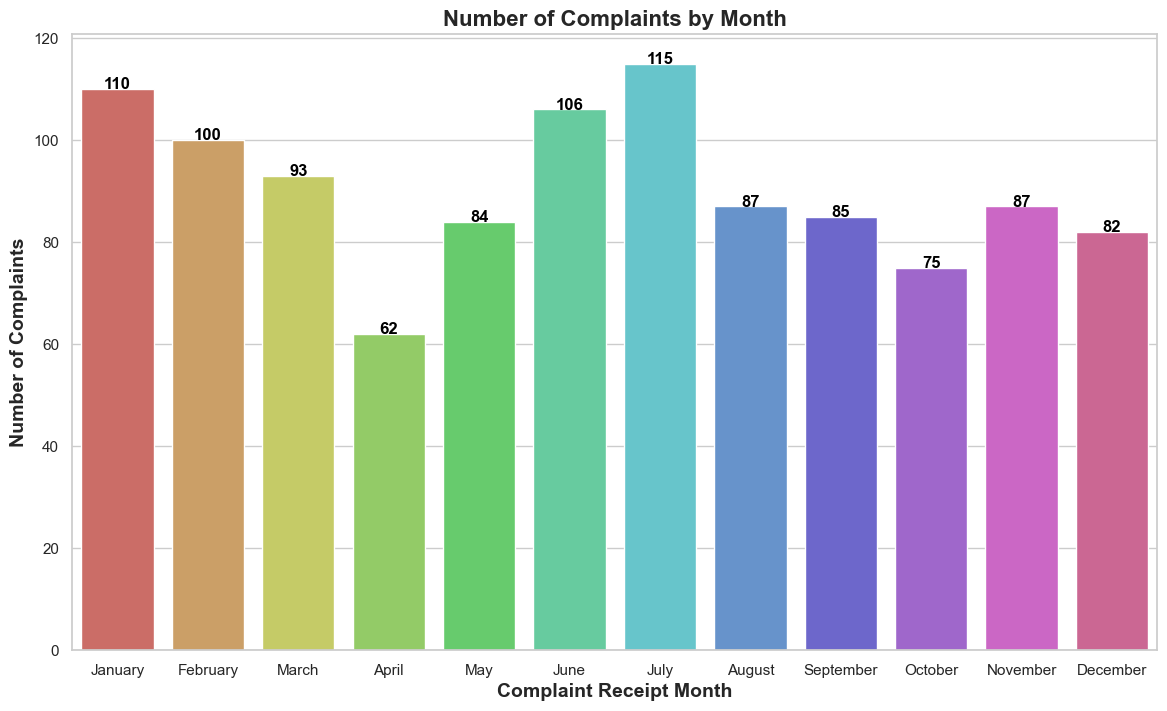

In [103]:
# Count Plot for Complaints by Month

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(x='Complaint Receipt Month', data=df_combined, palette='hls', hue='Complaint Receipt Month', legend=False)

# Add title and labels with professional formatting
plt.title('Number of Complaints by Month', fontsize=16, fontweight='bold')
plt.xlabel('Complaint Receipt Month', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Rotate the x-ticks for better readability
plt.xticks(rotation=0)

# Add the exact value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=12, color='black', fontweight='bold')

# Show the plot
plt.show()

This chart illustrates the distribution of complaints by month, revealing some notable seasonal trends. January and July stand out as the months with the highest number of complaints, with 110 and 115 respectively, indicating potential issues or heightened activity at the start and middle of the year. On the other hand, April has the lowest number of complaints, suggesting either a decrease in reporting during this month or perhaps effective resolution of issues early in the year. The steady number of complaints towards the end of the year, particularly in November and December, could reflect year-end processes or last-minute attempts to address unresolved issues. These trends could inform resource allocation and planning for handling complaints more effectively throughout the year.

#### Complaints over time, aggregated by month

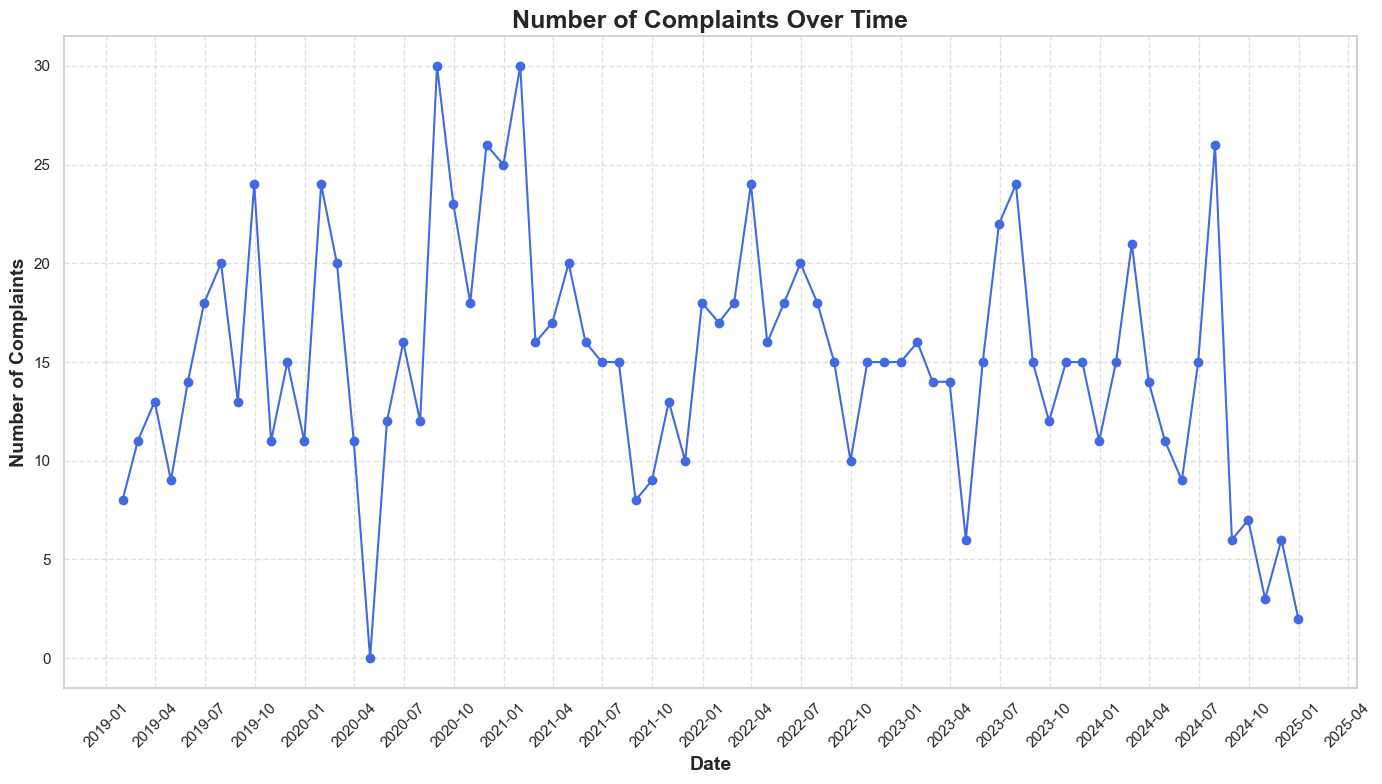

In [104]:
# Line Plot for complaints over time, aggregated by month

# Group by month and count the number of complaints
complaints_over_time = df_combined.resample('ME', on='Complaint Receipt Date').size()

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the time series of complaints
plt.plot(complaints_over_time.index, complaints_over_time.values, marker='o', linestyle='-', color='royalblue')

# Add titles and labels with professional formatting
plt.title('Number of Complaints Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Improve the x-axis date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

This line chart depicts the number of complaints over time, showcasing fluctuations in the volume of complaints across different months and years. Notable peaks and troughs are observed, indicating periods of increased or decreased complaint activity. The chart reveals a general pattern of variability rather than a consistent trend. For instance, there are several instances where the number of complaints spikes to around 30, followed by sharp declines. This could suggest external factors influencing the rate of complaints, such as policy changes, public awareness, or seasonal effects. The gradual decline toward the end of the period could indicate a reduction in complaints or a data cutoff as the current year progresses.

### Days of Treatment Viz

#### Box Plot for Minimum, Average, and Maximum Days of Treatment by Month

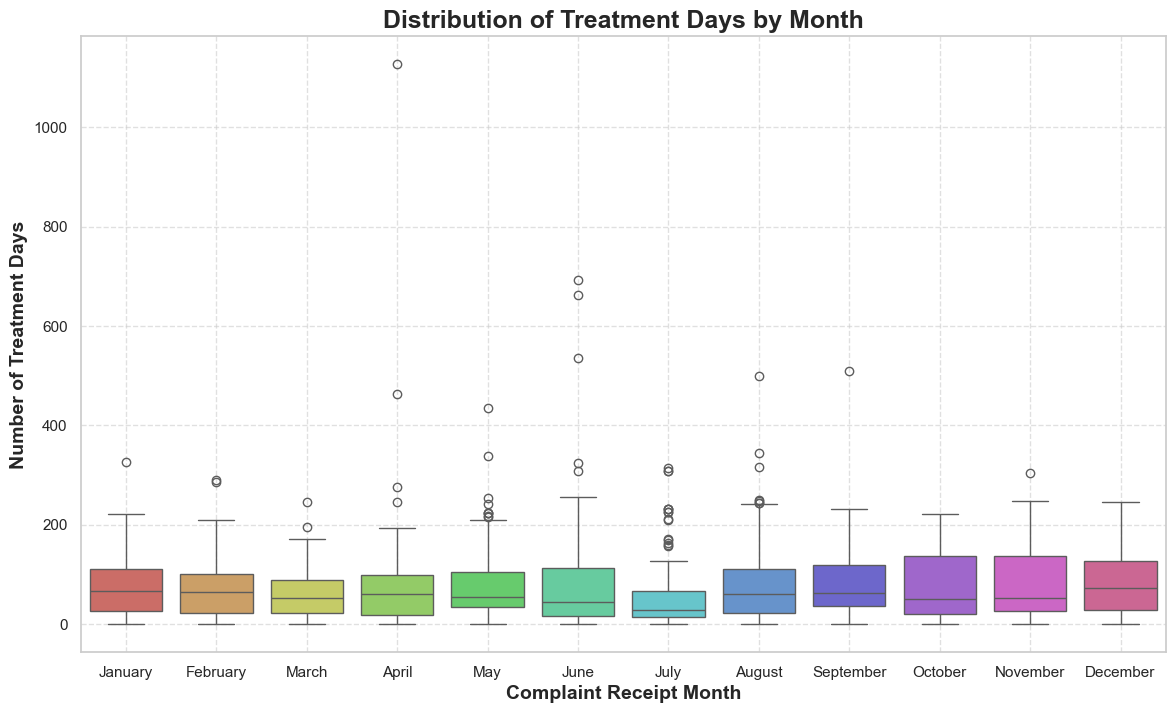

In [101]:
# Plot min, avg, max days of treatment by month

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a boxplot
ax = sns.boxplot(x='Complaint Receipt Month', y='Number of Treatment Days', hue='Complaint Receipt Month', data=df_combined, palette='hls', legend=False)

# Add title and labels with professional formatting
plt.title('Distribution of Treatment Days by Month', fontsize=18, fontweight='bold')
plt.xlabel('Complaint Receipt Month', fontsize=14)
plt.ylabel('Number of Treatment Days', fontsize=14)

# Optionally, add a grid to improve readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

The box plot showing the distribution of treatment days by month highlights that while the median treatment days remain relatively consistent across months, there are significant outliers, especially in months like June, July, and August. This suggests that although most complaints are resolved within a similar timeframe, some cases take considerably longer, particularly in these summer months. The presence of these outliers could indicate either particularly complex cases or potential delays in processing during these periods. Overall, the consistency in the median values suggests a steady workflow, but the outliers could be areas for process improvement.

In [42]:
# Entry with max Number of Treatment Days
df_combined[df_combined['Number of Treatment Days']==df_combined['Number of Treatment Days'].max()]

,_id,Complaint Number,Channel of Receipt,Initial Request Date for Information,Complaint Subject,Complaint Receipt Date,Entity Complained Against,Closing Date,Decision,Number of Treatment Days,Status,Complainant Type,Freedom of Information Request Subject,Complaint Receipt Year,Complaint Receipt Month,Initial Response Days,Justified
466,467,191/21,Email,2021-04-18,Lack of Justification,2021-04-26,בית חולים אסף הרופא,2024-05-27,Partially Justified,1127.0,Treatment Completed,אזרח,בדיקה בדיקה,2021,4,8,0


In [43]:
# Investigate entry with max treatment days

id_max_days_treatment = pd.to_numeric(df_combined[df_combined['Number of Treatment Days']==df_combined['Number of Treatment Days'].max()]['_id'].values[0])

max_days_treatment = df_combined.loc[id_max_days_treatment,'Number of Treatment Days']

print(f'The entry with the longest treatment days is id: {id_max_days_treatment}')
print(f'The treatment was {max_days_treatment} days')

The entry with the longest treatment days is id: 467
The treatment was 276.0 days


#### Box Plot for Minimum, Average, and Maximum Days of Treatment by Year

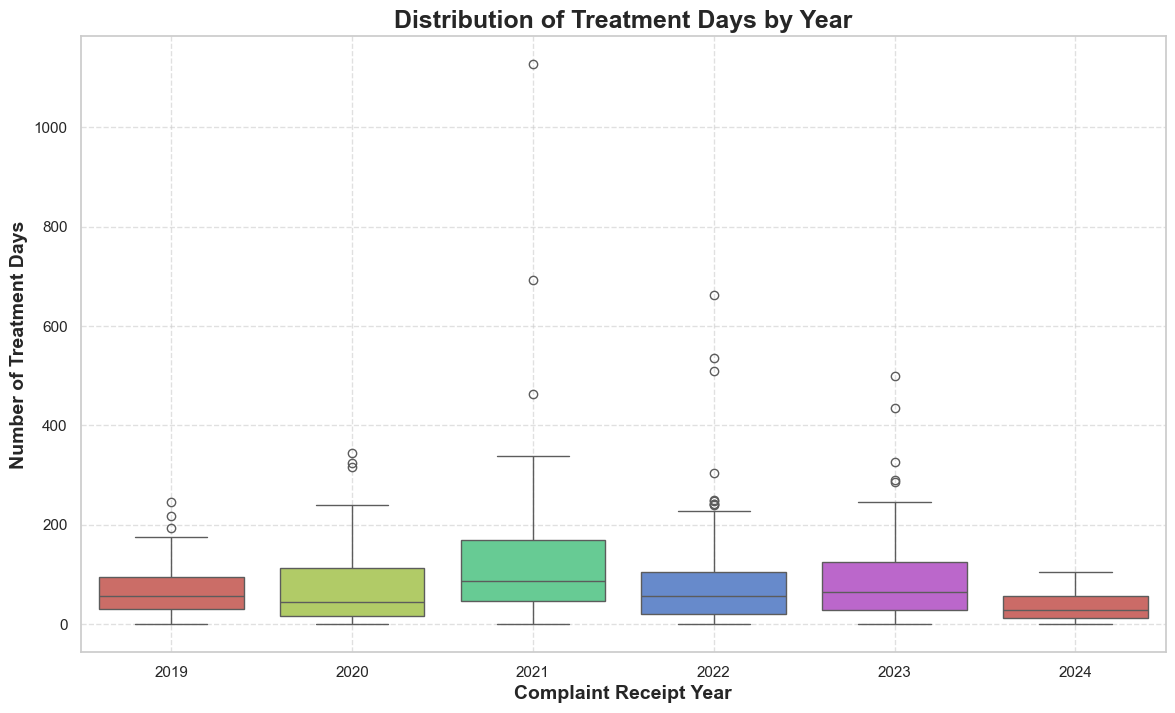

In [63]:
# 
# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a boxplot
ax = sns.boxplot(x='Complaint Receipt Year', y='Number of Treatment Days', hue='Complaint Receipt Year', data=df_combined, palette='hls', legend=False)

# Add title and labels with professional formatting
plt.title('Distribution of Treatment Days by Year', fontsize=18, fontweight='bold')
plt.xlabel('Complaint Receipt Year', fontsize=14)
plt.ylabel('Number of Treatment Days', fontsize=14)

# Optionally, add a grid to improve readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

The box plot showing the distribution of treatment days by year reveals a few key insights. The median number of treatment days appears consistent across the years, with slight variations. However, 2021 shows a higher variability in treatment times, indicated by the wider interquartile range and several outliers extending beyond 600 days. In contrast, 2024 shows a more compressed range, with fewer outliers and a lower median treatment time. This suggests potential improvements in complaint processing efficiency over time or changes in the types of complaints handled. The presence of outliers in most years indicates that certain cases still take significantly longer to resolve than others.

### Status Viz

#### Number of Complaints by Status

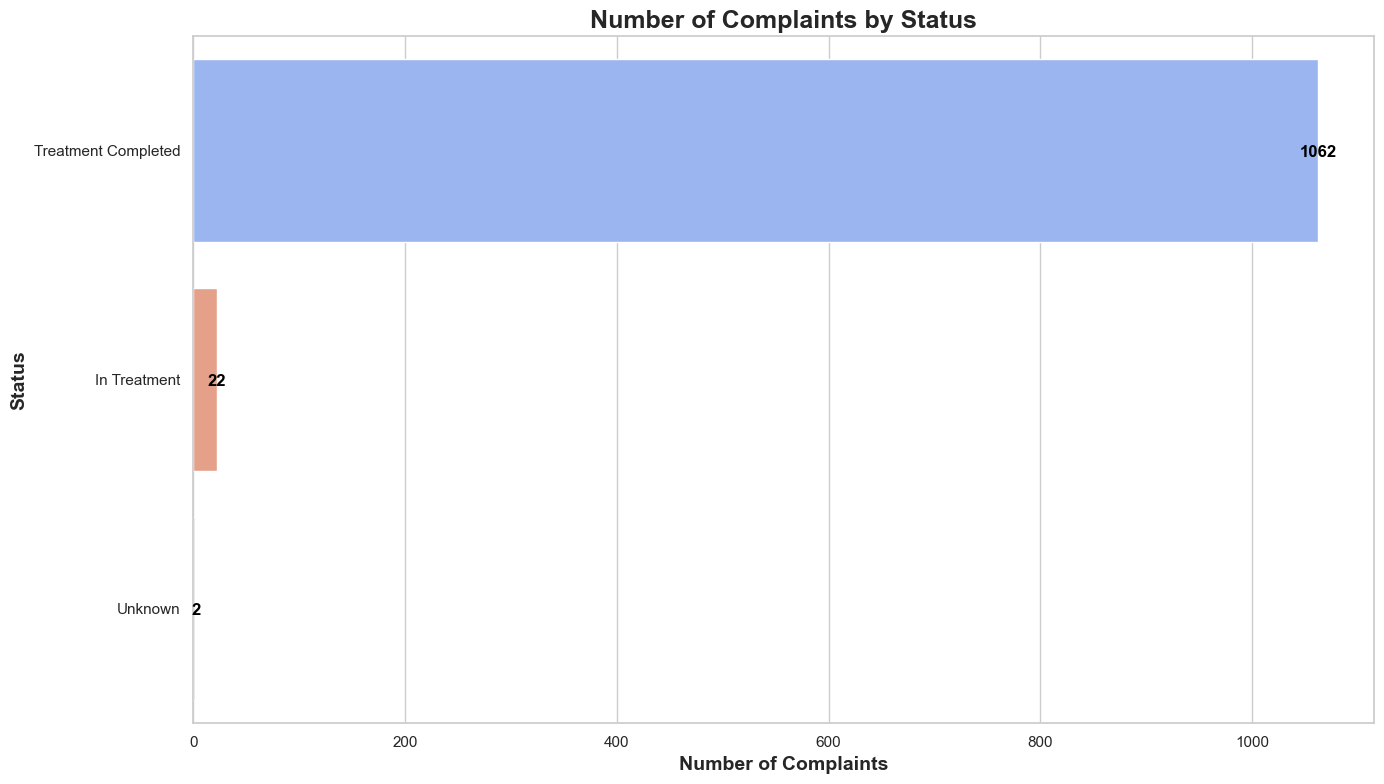

In [105]:
# Number of Complaints by Status

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(y='Status', 
                   data=df_combined, 
                   order=df_combined['Status'].value_counts().index, 
                   palette='coolwarm', 
                   legend=False, 
                   hue='Status')

# Add titles and labels
plt.title('Number of Complaints by Status', fontsize=18, fontweight='bold')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Status', fontsize=14)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

The bar chart illustrates the distribution of complaint statuses, revealing a clear dominance of cases where the treatment has been completed, accounting for 1,062 complaints. This overwhelmingly high number suggests that the majority of complaints reach a resolution, which is a positive indicator of the system's efficiency in processing and closing cases. In contrast, only 22 complaints are still in treatment, while a minimal 2 complaints have an "Unknown" status. This distribution highlights the effectiveness of the system in closing cases but also suggests that continuous monitoring is necessary to ensure that the few cases that are still open or unknown are addressed promptly.

In [42]:
# Percentages of each status calculation

# Calculate the total number of complaints
total_complaints = df_combined['Status'].count()

# Calculate the count of each status
status_counts = df_combined['Status'].value_counts()

# Calculate the percentage of each status
status_percentages = (status_counts / total_complaints) * 100

# Display the percentages
print("Percentages of each status:")
print(status_percentages)

Percentages of each status:
Status
Treatment Completed    97.790055
In Treatment            2.025783
Unknown                 0.184162
Name: count, dtype: float64


### Decision Viz

#### Number of Complaints by Decision

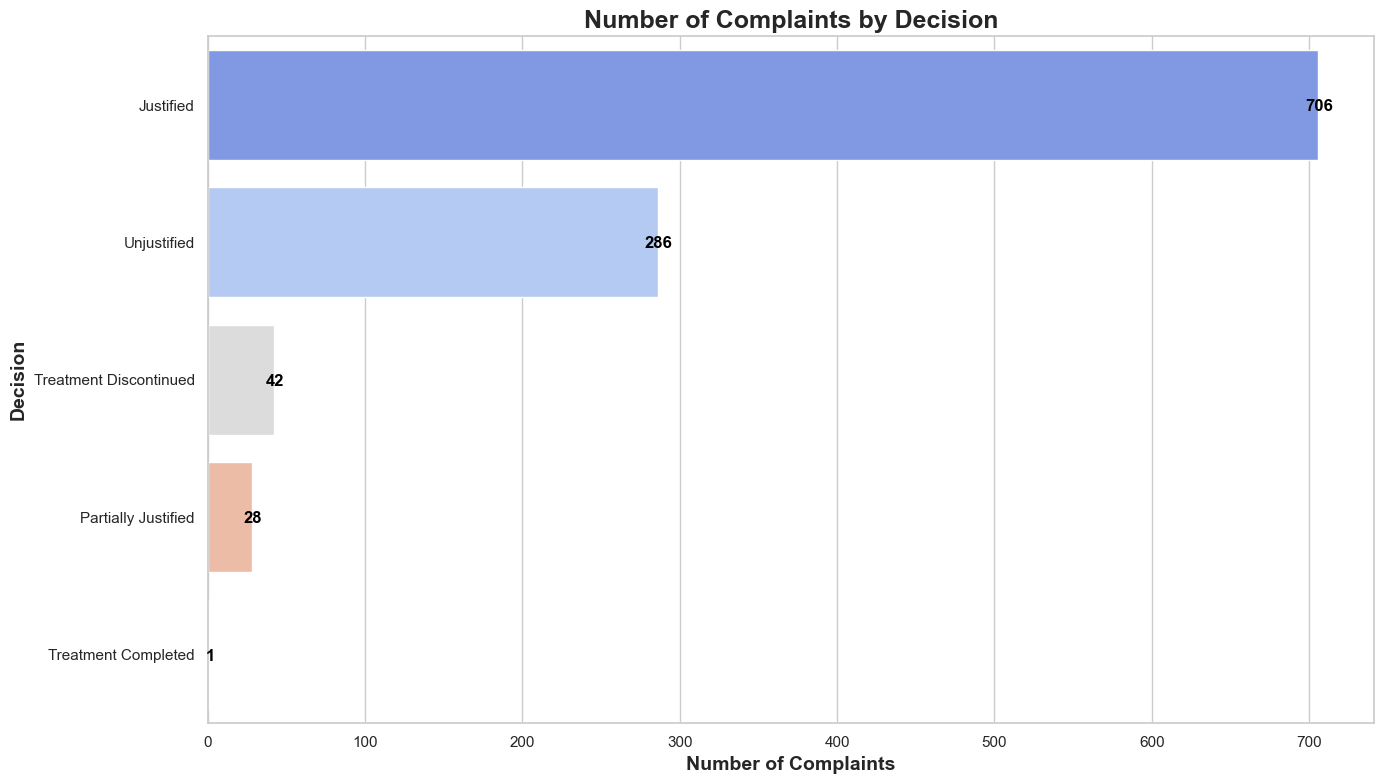

In [106]:
# Number of Complaints by Decision

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(y='Decision', 
                   data=df_combined, 
                   order=df_combined['Decision'].value_counts().index, 
                   palette='coolwarm', 
                   legend=False, 
                   hue='Decision')

# Add titles and labels
plt.title('Number of Complaints by Decision', fontsize=18, fontweight='bold')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Decision', fontsize=14)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

The bar chart illustrates the distribution of complaints by decision outcome, revealing that a significant majority of complaints (706) are deemed "Justified." This suggests that a large portion of complaints are found to have merit. Meanwhile, 286 complaints were categorized as "Unjustified," indicating that these cases did not meet the criteria for a valid complaint. There are smaller counts of "Treatment Discontinued" (42) and "Partially Justified" (28), with only one case marked as "Treatment Completed." This distribution underscores the effectiveness of the complaint evaluation process, with a focus on addressing and validating genuine grievances.

In [44]:
# Percentages of each Decision calculation

# Calculate the total number of complaints
total_complaints = df_combined['Decision'].count()

# Calculate the count of each status
decision_counts = df_combined['Decision'].value_counts()

# Calculate the percentage of each status
decision_percentages = (decision_counts / total_complaints) * 100

# Display the percentages
print("Percentages of each Decision:")
print(decision_percentages)

Percentages of each Decision:
Decision
Justified                 66.415804
Unjustified               26.904986
Treatment Discontinued     3.951082
Partially Justified        2.634055
Treatment Completed        0.094073
Name: count, dtype: float64


#### Number of Complaints by Decision and Year

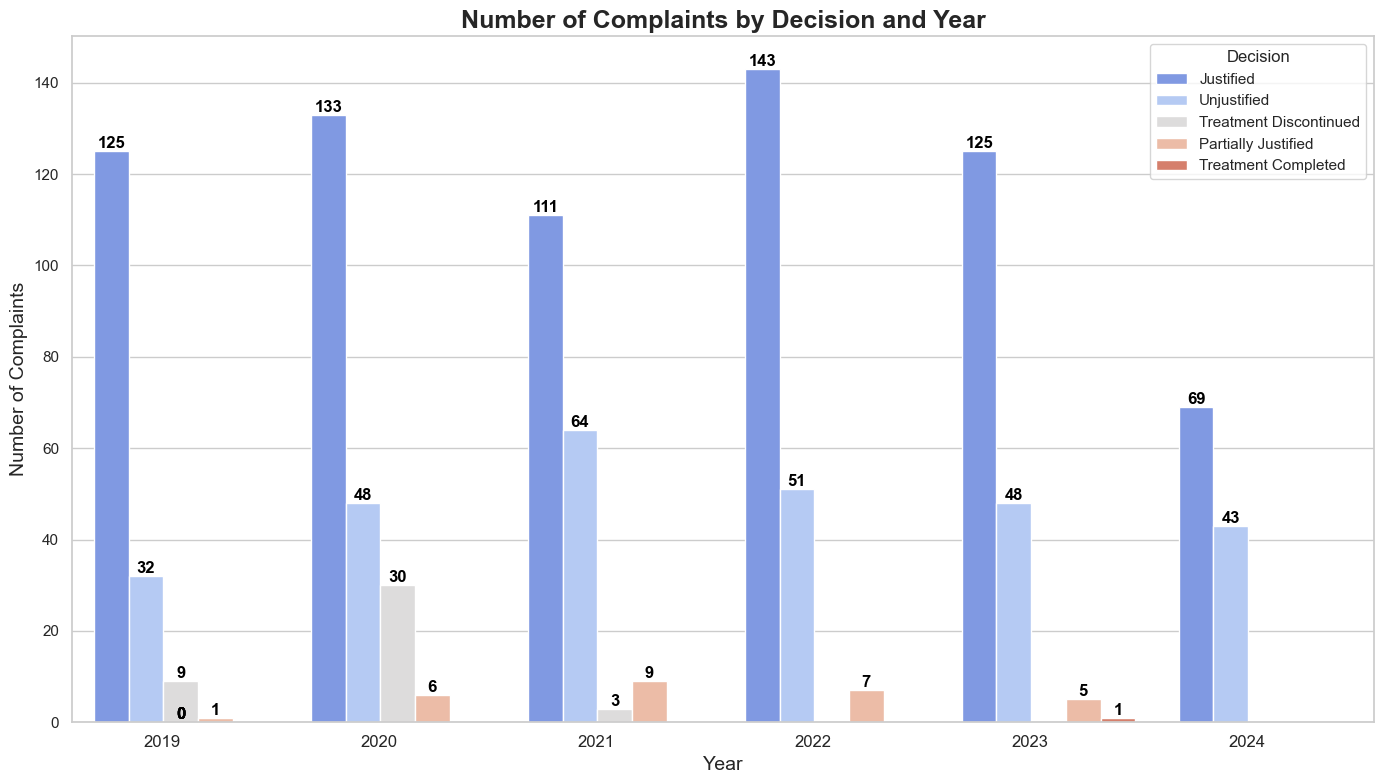

In [45]:
# Number of Complaints by Decision and Year

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(x='Complaint Receipt Year', 
                   hue='Decision', 
                   data=df_combined, 
                   palette='coolwarm')

# Add titles and labels
plt.title('Number of Complaints by Decision and Year', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12, color='black', fontweight='bold')

# Rotate the x-ticks for better readability
plt.xticks(rotation=0, ha='right', fontsize=12)

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

This visualization breaks down the number of complaints by decision and year, showing trends over time in how complaints are resolved. Notably, the number of "Justified" complaints consistently outweighs other outcomes each year, indicating a strong pattern of complaints being validated. There are fluctuations in the counts of "Unjustified" and "Partially Justified" complaints, with a notable peak in "Unjustified" complaints in 2021 and 2022. The "Treatment Discontinued" category remains relatively stable, while "Partially Justified" complaints are consistently low. The decline in total complaints in 2024 may suggest either fewer cases being filed or yet to be processed. Overall, the data suggests a steady and consistent approach to complaint resolution, with the majority of cases being deemed justified each year.

##### Average Time to Decision by Year

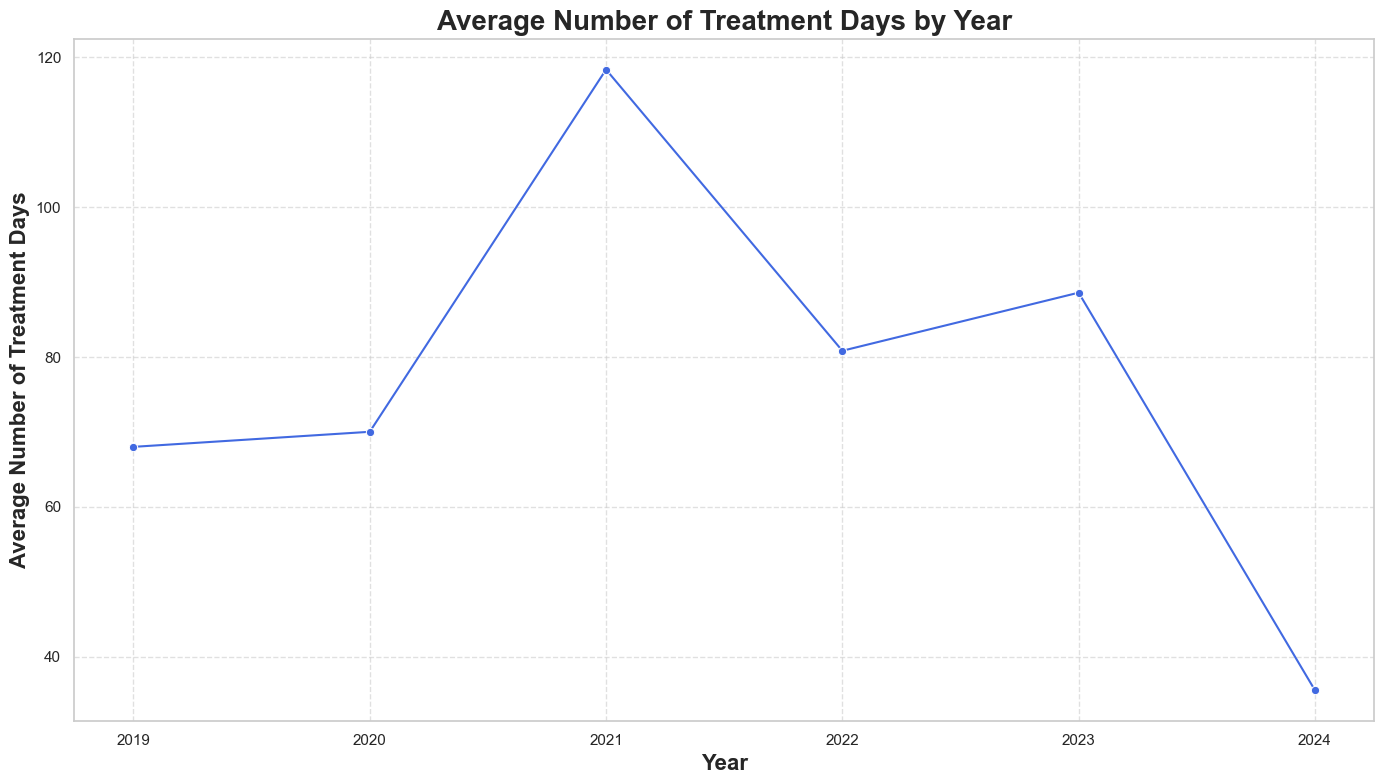

In [69]:
# Average Time to Decision by Year

# Calculate the average number of treatment days by year
avg_treatment_year = df_combined.groupby('Complaint Receipt Year')['Number of Treatment Days'].mean()

# Plot the average number of treatment days by year
plt.figure(figsize=(14, 8))
sns.lineplot(x=avg_treatment_year.index, y=avg_treatment_year.values, marker='o', color='royalblue')

# Add titles and labels
plt.title('Average Number of Treatment Days by Year', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Average Number of Treatment Days', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This line chart illustrates the average number of treatment days by year. We observe a sharp increase in the average number of treatment days in 2021, peaking at around 120 days, followed by a noticeable decline in the subsequent years. By 2024, the average number of treatment days has decreased significantly, dropping to around 40 days. This trend suggests that there may have been factors in 2021 that caused delays or longer processing times, but recent years show improvements in reducing the time required to address complaints. The decline in treatment days could reflect efficiency gains or a change in the nature of complaints being filed.

### Complaint Subject Viz

#### Count plot with the complaint subjects

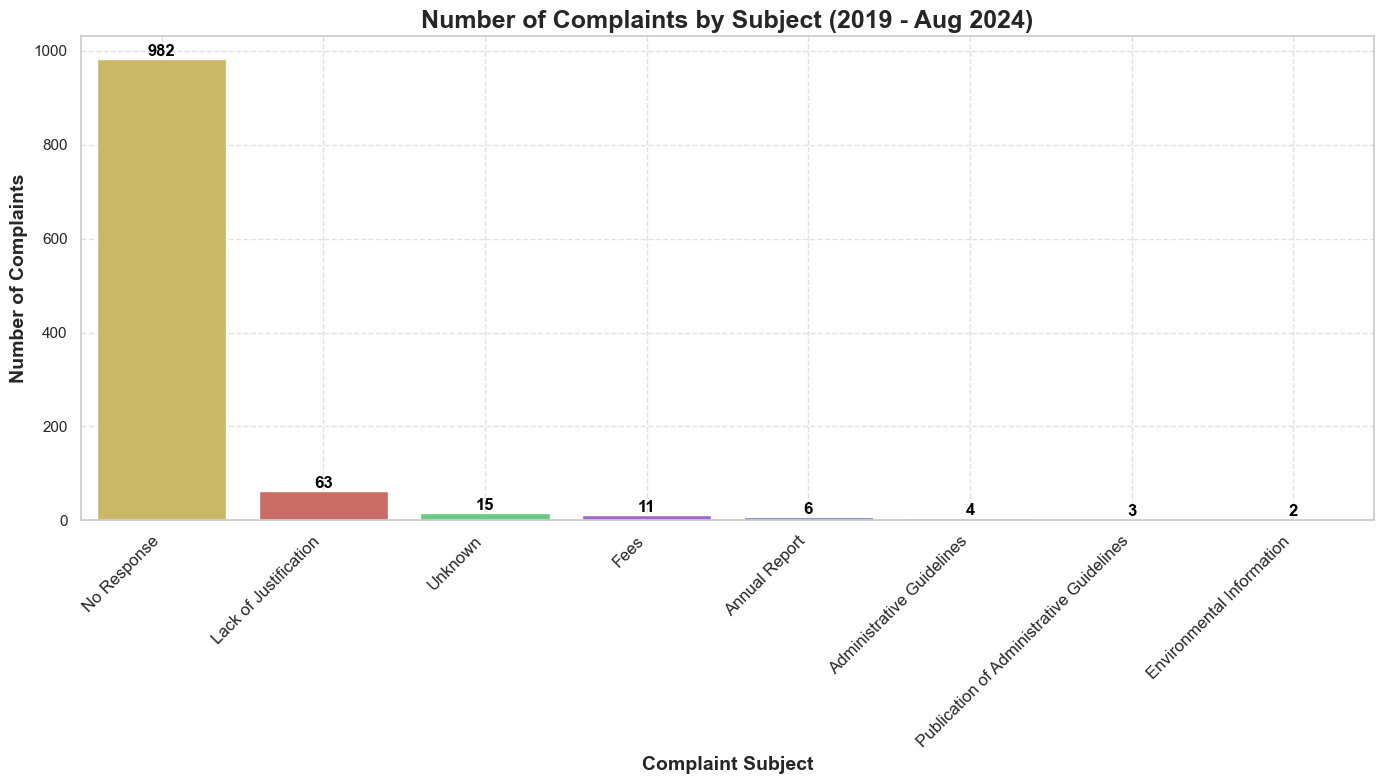

In [74]:
# Count plot with the complaint subjects

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(x='Complaint Subject', data=df_combined, palette='hls', 
                   order=df_combined['Complaint Subject'].value_counts().index,
                   hue = 'Complaint Subject', legend = False)

# Add title and labels with professional formatting
plt.title('Number of Complaints by Subject (2019 - Aug 2024)', fontsize=18, fontweight='bold')
plt.xlabel('Complaint Subject', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add the values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12, color='black', fontweight='bold')

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust the layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

This bar chart illustrates the distribution of complaints by subject, with a striking dominance of complaints categorized under "No Response," which accounts for 982 out of the total complaints. This category vastly overshadows other complaint subjects, with the next most common category, "Lack of Justification," registering only 63 complaints. The significant disparity suggests that failure to respond is the most prevalent issue faced by complainants, indicating a potential systemic problem in communication or responsiveness from the entities involved. Other categories, such as "Unknown," "Fees," and "Annual Report," have minimal representation, further highlighting the overwhelming prominence of response-related issues. This insight could prompt a deeper investigation into why "No Response" complaints are so predominant and what measures could be implemented to address this issue.

In [72]:
# Percentages of each Complaint Subject calculation

# Calculate the total number of complaints
total_complaints = df_combined['Complaint Subject'].count()

# Calculate the count of each Subject
complaint_subject_counts = df_combined['Complaint Subject'].value_counts()

# Calculate the percentage of each status
decision_percentages = (complaint_subject_counts / total_complaints) * 100

# Display the percentages
print("Percentages of each Complaint Subject:")
print(decision_percentages)

Percentages of each Complaint Subject:
Complaint Subject
No Response                                 90.423573
Lack of Justification                        5.801105
Unknown                                      1.381215
Fees                                         1.012891
Annual Report                                0.552486
Administrative Guidelines                    0.368324
Publication of Administrative Guidelines     0.276243
Environmental Information                    0.184162
Name: count, dtype: float64


Note: Above 90% of complaints regard No Response 'אי מתן מענה' as subject.

#### Number of Complaints by Year, Categorized by Complaint Subject

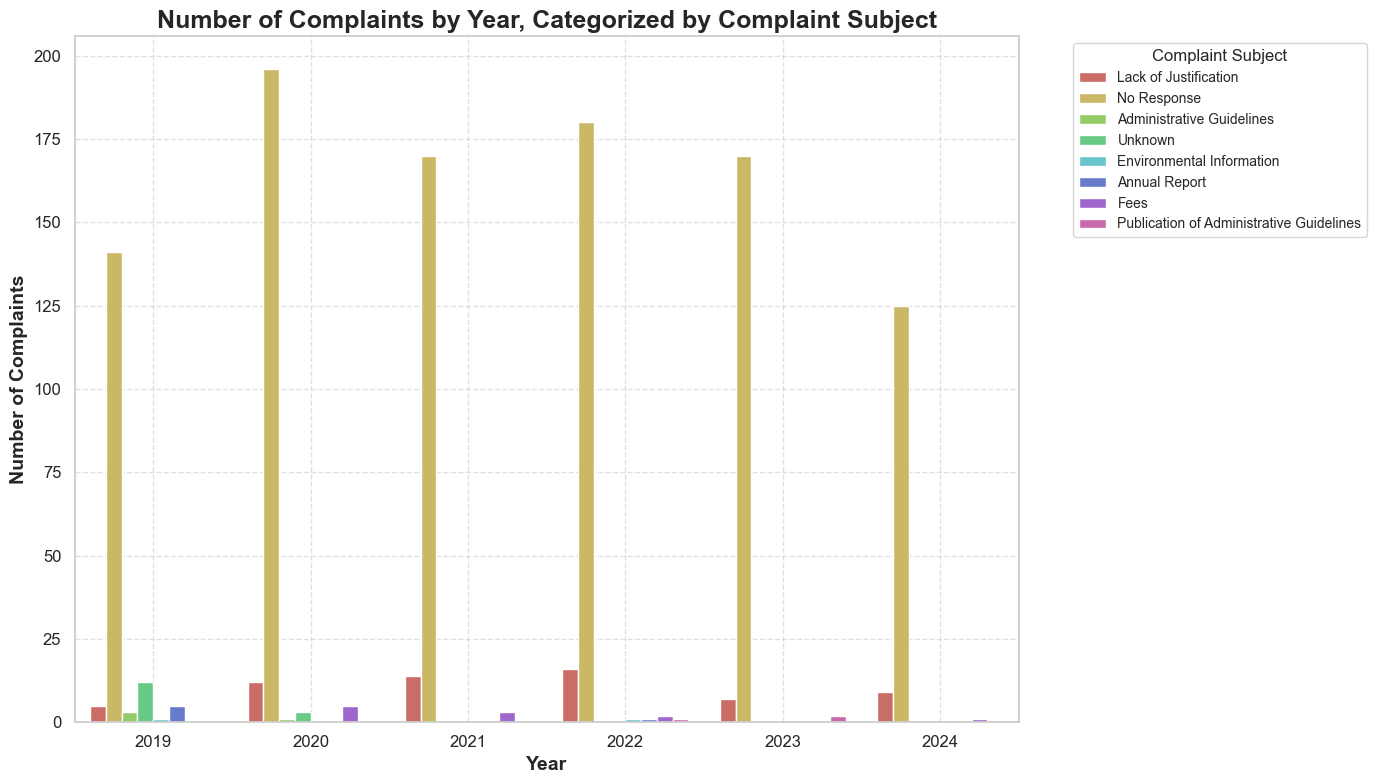

In [73]:
# Number of Complaints by Year, Categorized by Complaint Subject

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(x='Complaint Receipt Year', hue='Complaint Subject', data=df_combined, palette='hls')

# Add title and labels with professional formatting
plt.title('Number of Complaints by Year, Categorized by Complaint Subject', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Rotate the x-ticks for better readability
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title='Complaint Subject', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

This visualization depicts the number of complaints by year, categorized by complaint subject. It is evident that the "No Response" category overwhelmingly dominates each year, reinforcing the trend observed in the earlier visualization where this issue was the most significant concern across all years. The consistency in the high volume of "No Response" complaints year after year suggests a persistent systemic issue that has not been adequately addressed over time. Other complaint subjects, like "Lack of Justification" and "Unknown," have relatively low and stable counts, indicating that they are less prevalent but still recurring concerns. This chart underscores the need for targeted interventions to address the communication gaps represented by the "No Response" category.

#### Average Number of Treatment Days by Complaint Subject

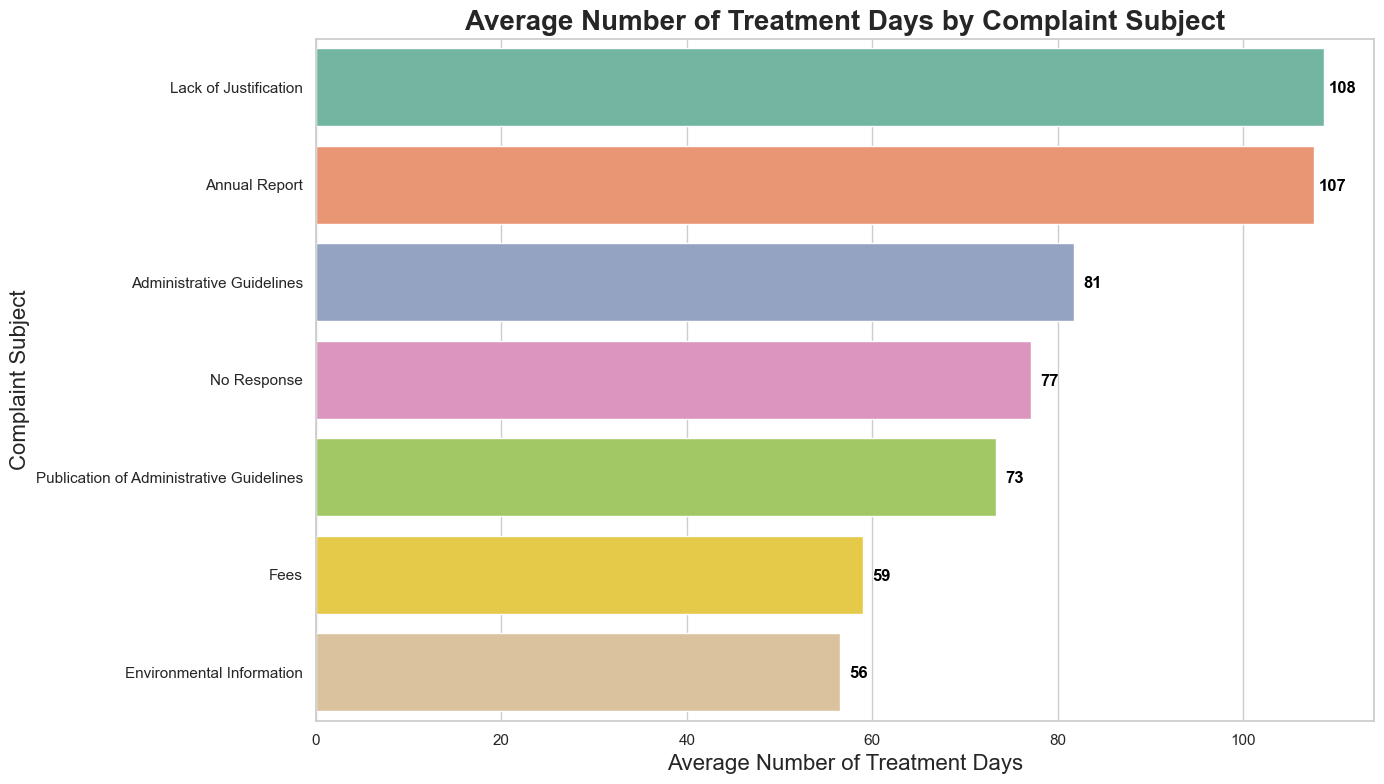

In [49]:
# Average Number of Treatment Days by Complaint Subject

# Exclude rows where Complaint Subject is 'Unknown'
filtered_df = df_combined[df_combined['Complaint Subject'] != 'Unknown']

# Calculate the average number of treatment days by complaint subject
avg_treatment_subject = filtered_df.groupby('Complaint Subject')['Number of Treatment Days'].mean().sort_values(ascending=False)

# Plot the average number of treatment days by complaint subject
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=avg_treatment_subject.values, y=avg_treatment_subject.index, hue=avg_treatment_subject.index, palette='Set2', legend=False)

# Add the exact average number of treatment days on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 2, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')
    
# Add titles and labels
plt.title('Average Number of Treatment Days by Complaint Subject', fontsize=20, fontweight='bold')
plt.xlabel('Average Number of Treatment Days', fontsize=16)
plt.ylabel('Complaint Subject', fontsize=16)

plt.tight_layout()
plt.show()


This visualization displays the average number of treatment days by complaint subject, revealing significant differences in response times based on the nature of the complaint. Complaints related to "Lack of Justification" and "Annual Report" have the highest average treatment days, indicating that these issues might be more complex or require more in-depth investigation. In contrast, subjects like "Environmental Information" and "Fees" have the shortest average treatment times, suggesting they might be more straightforward to resolve. Notably, "No Response" complaints, while high in volume, have a moderate average treatment time, hinting at a systemic issue with initial communication but potentially quicker resolution once addressed. This insight could guide prioritization and resource allocation for different types of complaints.

##### Trends in Complaint Subjects Over Time

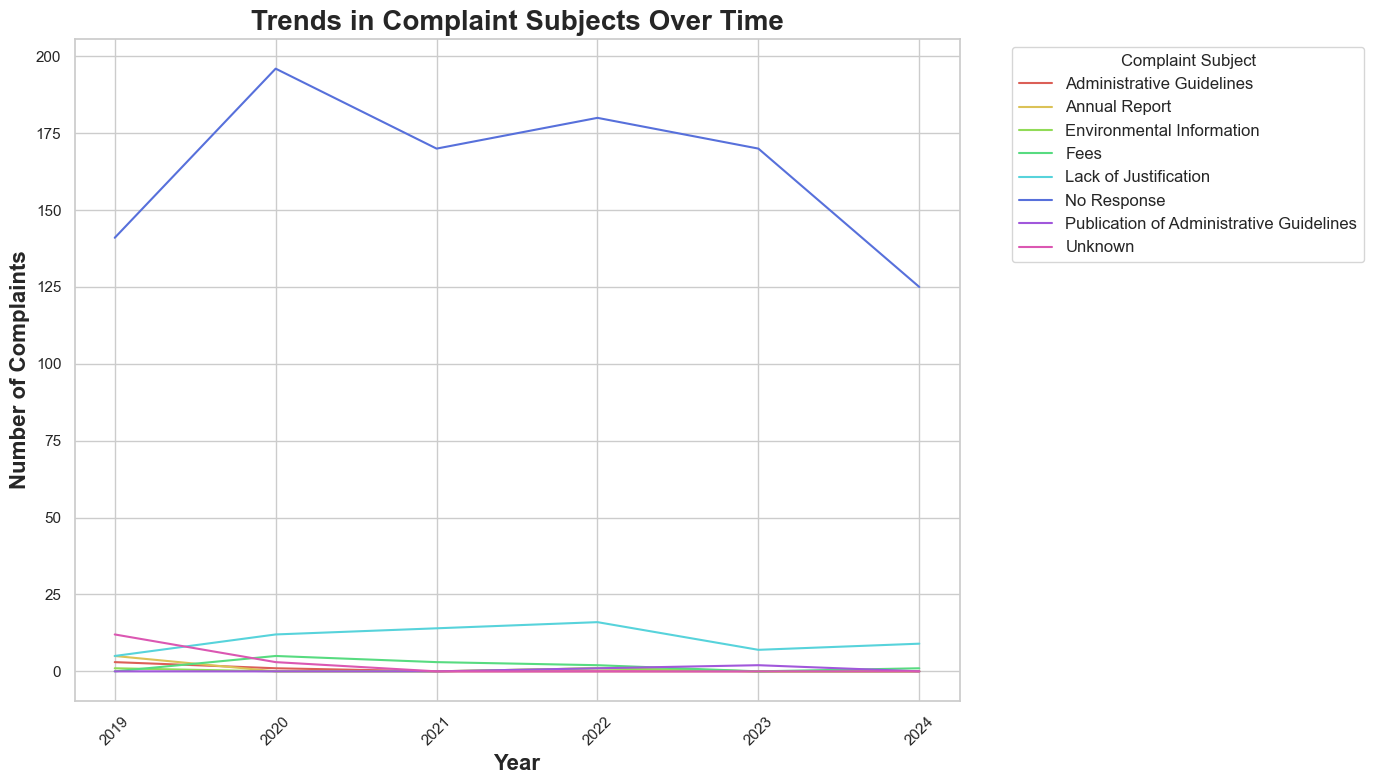

In [107]:
# Trends in Complaint Subjects Over Time

# Group data by year and complaint subject, and count the number of complaints
complaints_by_subject_year = df_combined.groupby(['Complaint Receipt Year', 'Complaint Subject']).size().reset_index(name='Complaint Count')

# Pivot the table to get years as columns and complaint subjects as rows
complaints_pivot = complaints_by_subject_year.pivot(index='Complaint Subject', columns='Complaint Receipt Year', values='Complaint Count').fillna(0)

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot each complaint subject's trend over time
sns.lineplot(data=complaints_pivot.T, dashes=False, palette='hls')

# Add title and labels with professional formatting
plt.title('Trends in Complaint Subjects Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)

# Customize legend for better readability
plt.legend(title='Complaint Subject', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

This visualization highlights the trends in various complaint subjects over time. It is clear that "No Response" is consistently the most prevalent complaint subject, far surpassing other categories each year. This trend suggests a systemic issue with response management that has persisted over time. Other categories, such as "Lack of Justification," "Administrative Guidelines," and "Annual Report," show relatively stable and low complaint volumes across the years, indicating that these are less frequent but still ongoing issues. The overall decline in complaints related to "No Response" in recent years could suggest improvements in addressing this issue or a shift in how complaints are categorized. Understanding the reasons behind these trends could inform targeted improvements in service delivery and complaint handling.

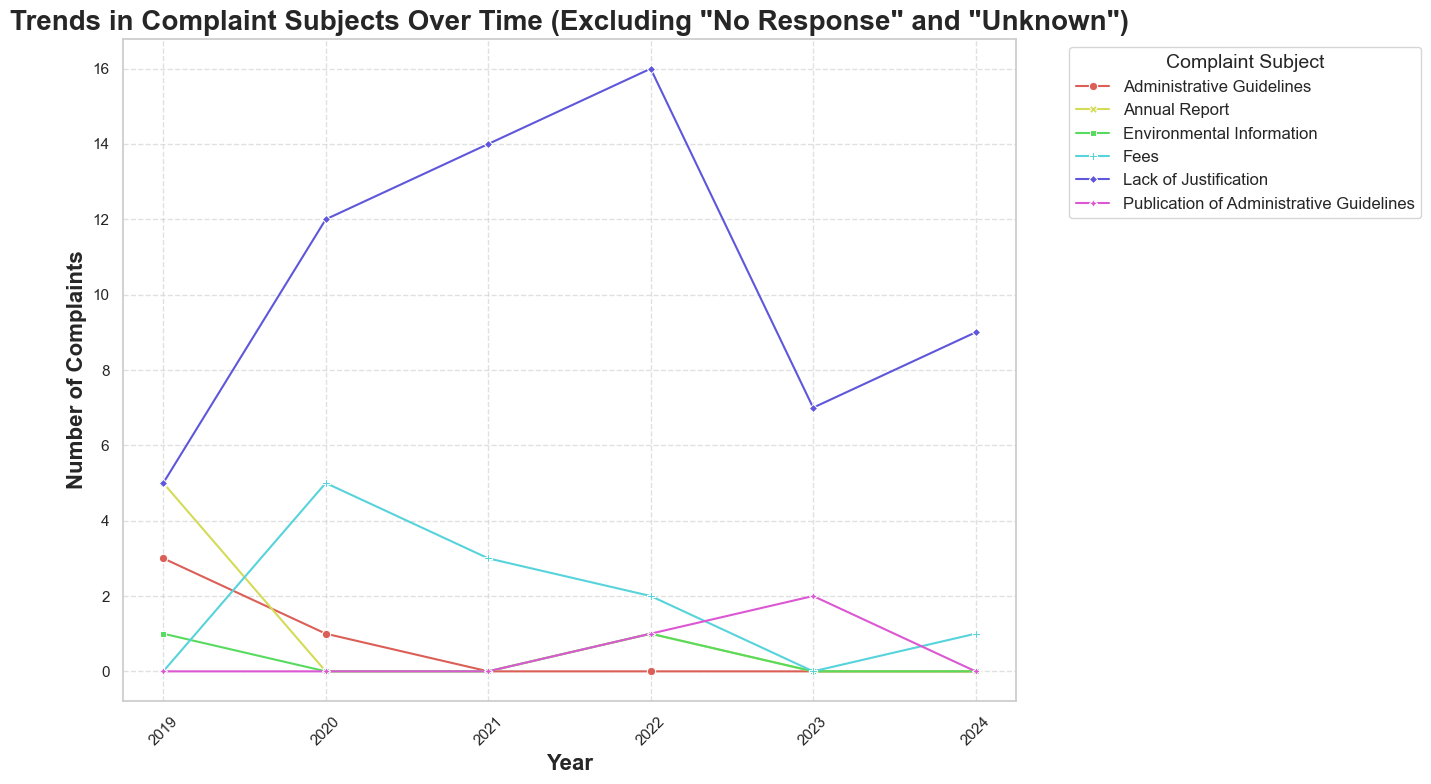

In [108]:
# Trends in Complaint Subjects Over Time (Excluding 'No Response' and 'Unknown')

# Filter out 'No Response' and 'Unknown' from the dataset
filtered_df = df_combined[~df_combined['Complaint Subject'].isin(['No Response', 'Unknown'])]

# Group data by year and complaint subject, and count the number of complaints
complaints_by_subject_year = filtered_df.groupby(['Complaint Receipt Year', 'Complaint Subject']).size().reset_index(name='Complaint Count')

# Pivot the table to get years as columns and complaint subjects as rows
complaints_pivot = complaints_by_subject_year.pivot(index='Complaint Subject', columns='Complaint Receipt Year', values='Complaint Count').fillna(0)

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot each complaint subject's trend over time
sns.lineplot(data=complaints_pivot.T, dashes=False, markers=True, palette="hls")

# Add title and labels with professional formatting
plt.title('Trends in Complaint Subjects Over Time (Excluding "No Response" and "Unknown")', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)

# Customize legend for better readability
plt.legend(title='Complaint Subject', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Adjust the grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

This visualization shows the trends in specific complaint subjects over time, excluding the dominant categories of "No Response" and "Unknown" to focus on less frequent but potentially significant issues. The most notable trend is the increase in complaints categorized under "Lack of Justification," which peaks in 2022 before slightly declining. Other subjects like "Administrative Guidelines" and "Publication of Administrative Guidelines" show more stability, with only minor fluctuations over the years. The rise in "Fees" complaints in recent years may indicate emerging concerns in this area. This chart suggests that while some issues are persistent, others may be gaining more attention or becoming more prevalent over time.

#### Distribution of Initial Response Days by Year

The means are represented as red dots.


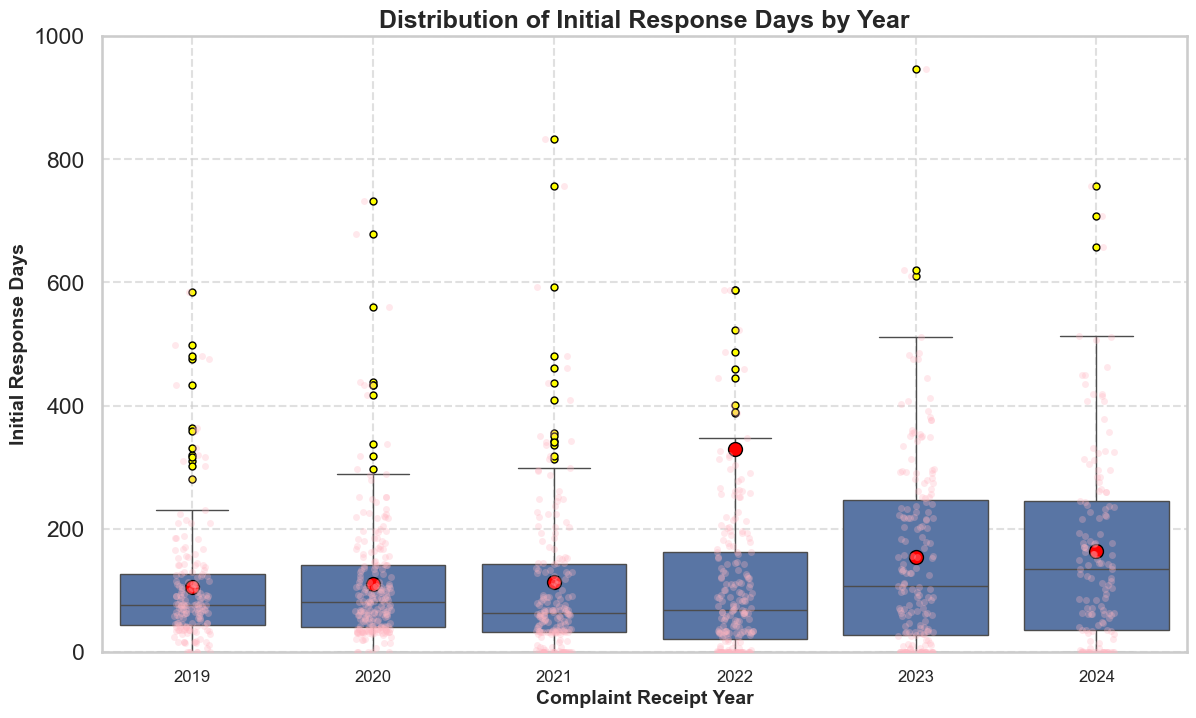

In [83]:
# Distribution of Initial Response Days by Year

# Set a style and context for the plot to improve its aesthetics
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 8))

# Create the box plot with more descriptive elements
sns.boxplot(
    x='Complaint Receipt Year',
    y='Initial Response Days',
    data=df_combined,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": "10"},
    flierprops={"marker": "o", "markerfacecolor": "yellow", "markeredgecolor": "black", "markersize": "5"}
)

print('The means are represented as red dots.')
# Highlight the mean and add data points over the box plot for more detail
sns.stripplot(
    x='Complaint Receipt Year',
    y='Initial Response Days',
    data=df_combined,
    jitter=True,
    dodge=True,
    alpha=0.3,
    color='lightpink'
)

# Adding a title and labels with more detail and improved readability
plt.title('Distribution of Initial Response Days by Year', fontsize=18, weight='bold')
plt.xlabel('Complaint Receipt Year', fontsize=14)
plt.ylabel('Initial Response Days', fontsize=14)

# Improving y-axis limit based on the observed data
plt.ylim(0, 1000) 

# Ensure x-axis labels are readable
plt.xticks(rotation=0, fontsize=12)

# Adding a grid for better visual separation of data points
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

This visualization highlights the distribution of initial response days across different years. Notably, there are substantial outliers each year, indicating instances where responses were significantly delayed. Despite the presence of these outliers, the median response time appears relatively stable across the years, with only minor fluctuations. The interquartile range (IQR) remains consistent, suggesting that most complaints receive a response within a similar timeframe each year. However, the presence of numerous outliers indicates that for a subset of cases, response times can be highly variable and extended, pointing to potential inefficiencies or exceptions in the handling of certain complaints.

#### Distribution of Initial Response Days by Month

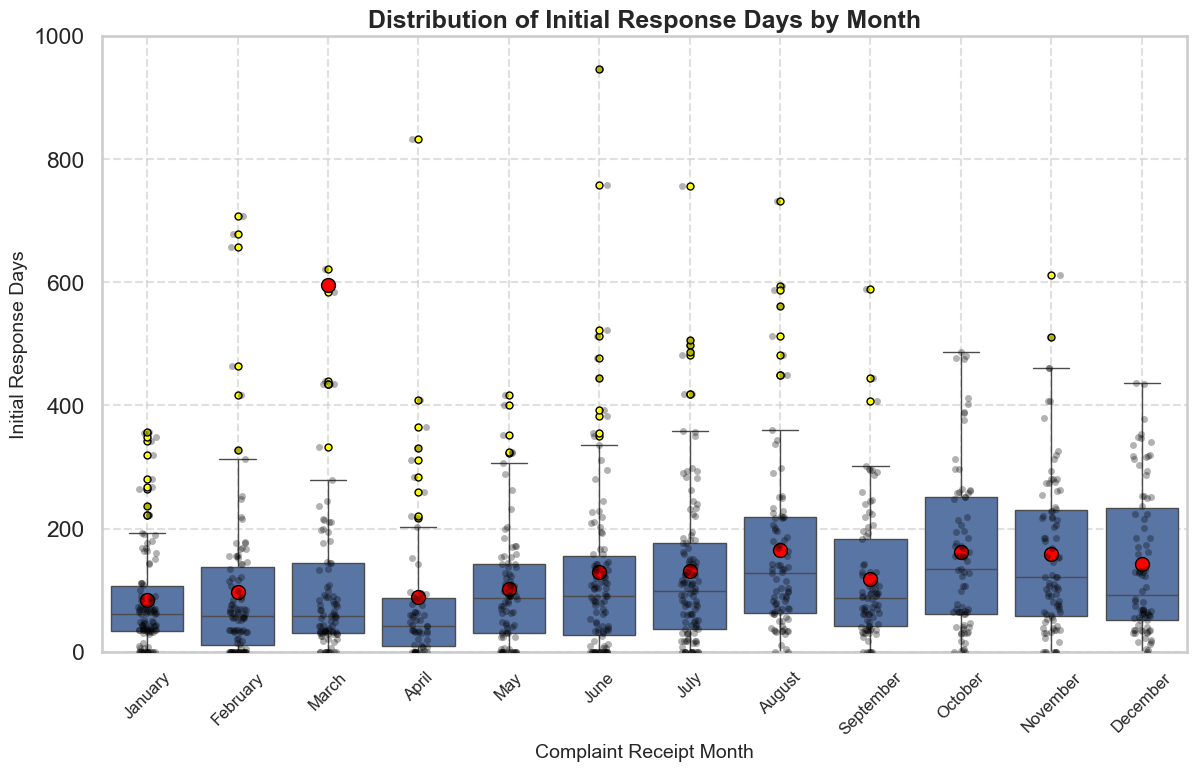

In [53]:
# Distribution of Initial Response Days by Year

# Set a style and context for the plot to improve its aesthetics
sns.set(style="whitegrid", context="talk")

# Convert 'Complaint Receipt Date' to datetime if not already done, and extract the month
df_combined['Complaint Receipt Month'] = df_combined['Complaint Receipt Date'].dt.strftime('%B')

# Sort the months to ensure they appear in chronological order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

plt.figure(figsize=(14, 8))

# Create the box plot with more descriptive elements
sns.boxplot(
    x='Complaint Receipt Month',
    y='Initial Response Days',
    data=df_combined,
    showmeans=True,
    order=month_order,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": "10"},
    flierprops={"marker": "o", "markerfacecolor": "yellow", "markeredgecolor": "black", "markersize": "5"}
)

# Highlight the mean and add data points over the box plot for more detail
sns.stripplot(
    x='Complaint Receipt Month',
    y='Initial Response Days',
    data=df_combined,
    jitter=True,
    dodge=True,
    alpha=0.3,
    color='black',
    order=month_order
)

# Adding a title and labels with more detail and improved readability
plt.title('Distribution of Initial Response Days by Month', fontsize=18, weight='bold')
plt.xlabel('Complaint Receipt Month', fontsize=14)
plt.ylabel('Initial Response Days', fontsize=14)

# Improving y-axis limit based on the observed data
plt.ylim(0, 1000) 

# Ensure x-axis labels are readable
plt.xticks(rotation=45, fontsize=12)

# Adding a grid for better visual separation of data points
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

This visualization shows the distribution of initial response days by month. It highlights that there is considerable variability in response times throughout the year, with outliers present in every month, indicating instances of particularly delayed responses. The median response time seems relatively consistent across months, but some months like July and September have higher median response times compared to others. Additionally, certain months such as May and July exhibit more dispersed response times, as indicated by the wider interquartile ranges (IQR). This suggests potential periods of inefficiency or higher workload that might contribute to delayed responses during these months.

### Channel of Receipt Viz

#### Count Plot for Channel of Receipt

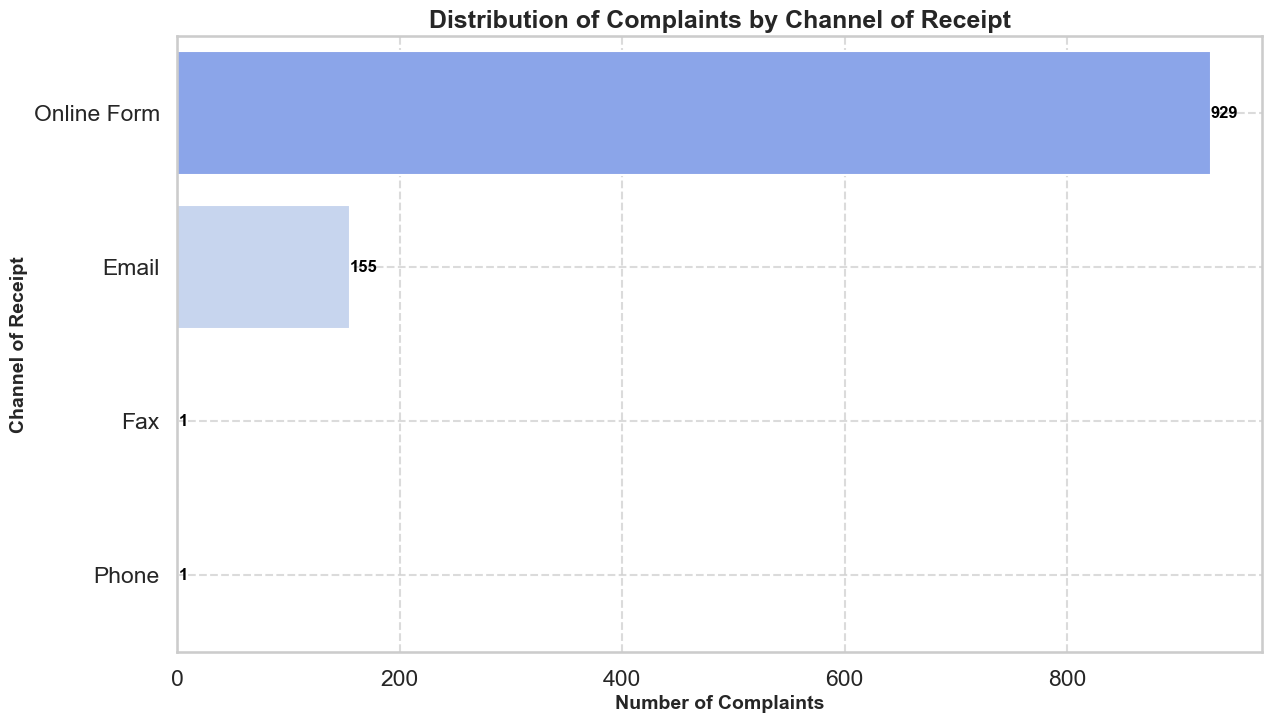

In [109]:
# Count Plot for Channel of Receipt

# Set a style and context for the plot to improve its aesthetics
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 8))

# Create the count plot for 'Channel of Receipt'
sns.countplot(
    y='Channel of Receipt',  # Horizontal bar plot for better readability with longer category names
    data=df_combined,
    order=df_combined['Channel of Receipt'].value_counts().index,  # Order by frequency
    palette='coolwarm',
    hue='Channel of Receipt',
    legend=False
)

# Adding a title and labels with more detail and improved readability
plt.title('Distribution of Complaints by Channel of Receipt', fontsize=18, weight='bold')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Channel of Receipt', fontsize=14)

# Annotate bars with the count of complaints
for index, value in enumerate(df_combined['Channel of Receipt'].value_counts()):
    plt.text(value, index, str(value), va='center', fontsize=12, color='black', weight='bold')

# Adding a grid for better visual separation of data points
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

This visualization indicates that the overwhelming majority of complaints are submitted through the online form, accounting for 929 out of the total complaints. Email is the second most common channel, with 155 complaints received through this method. The use of fax and phone is negligible, with only one complaint each. This suggests a strong preference or perhaps an organizational push towards digital channels, particularly online forms, for submitting complaints. The heavy reliance on online forms might indicate their accessibility or the convenience they offer compared to other methods.

#### Number of Complaints by Year, Categorized by Channel of Receipt

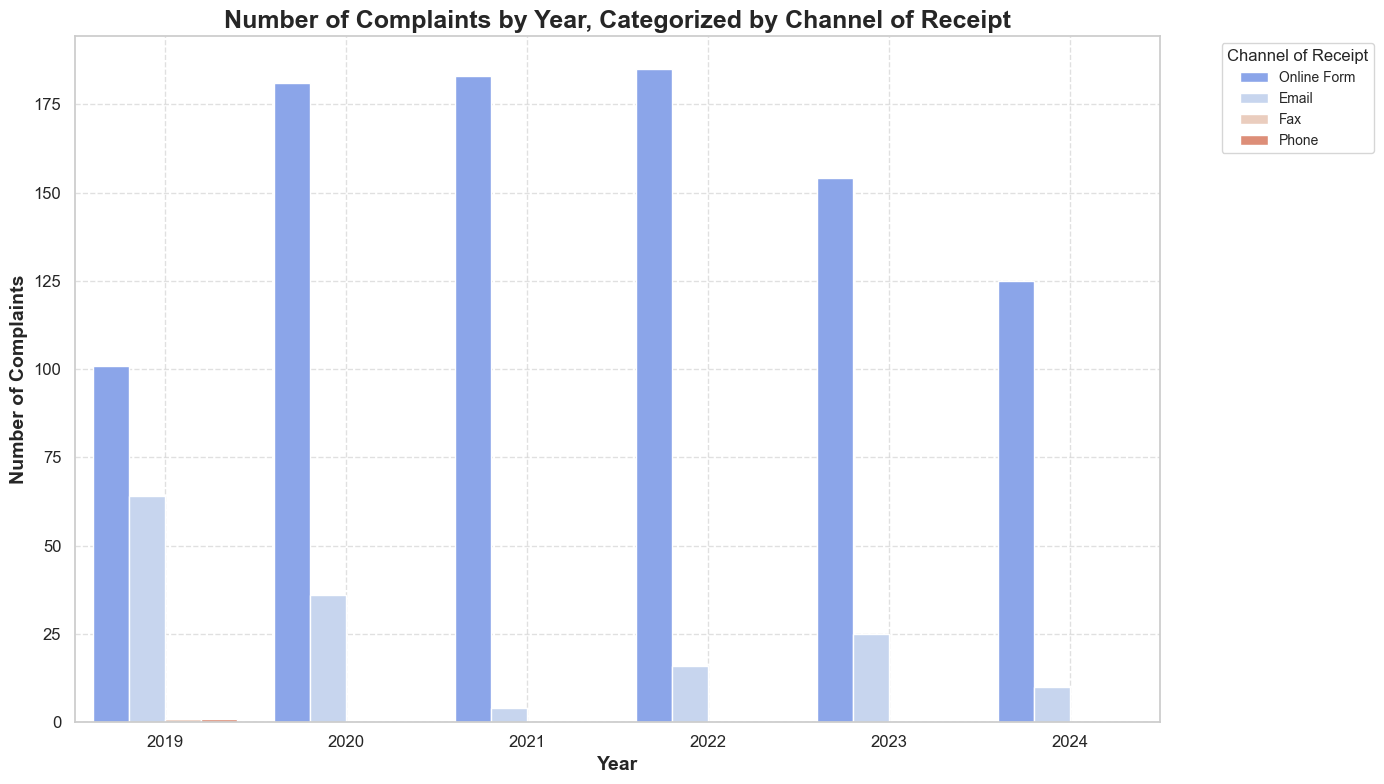

In [85]:
# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a countplot
ax = sns.countplot(x='Complaint Receipt Year', hue='Channel of Receipt', data=df_combined, palette='coolwarm')

# Add title and labels with professional formatting
plt.title('Number of Complaints by Year, Categorized by Channel of Receipt', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

# Rotate the x-ticks for better readability
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title='Channel of Receipt', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

This visualization shows the distribution of complaints by year, categorized by the channel of receipt. Across all years, the online form has consistently been the dominant channel for submitting complaints. Email is the second most used channel, though significantly less frequent than online forms. The use of fax and phone is negligible and shows no significant variation over the years. This trend suggests a strong preference or effectiveness of digital channels, particularly online forms, for lodging complaints, with very minimal reliance on traditional communication methods. The consistency across years indicates a stable pattern in how complaints are received.

### Entity Complained Against Viz

#### Top 10 entities that were most frequently complained against

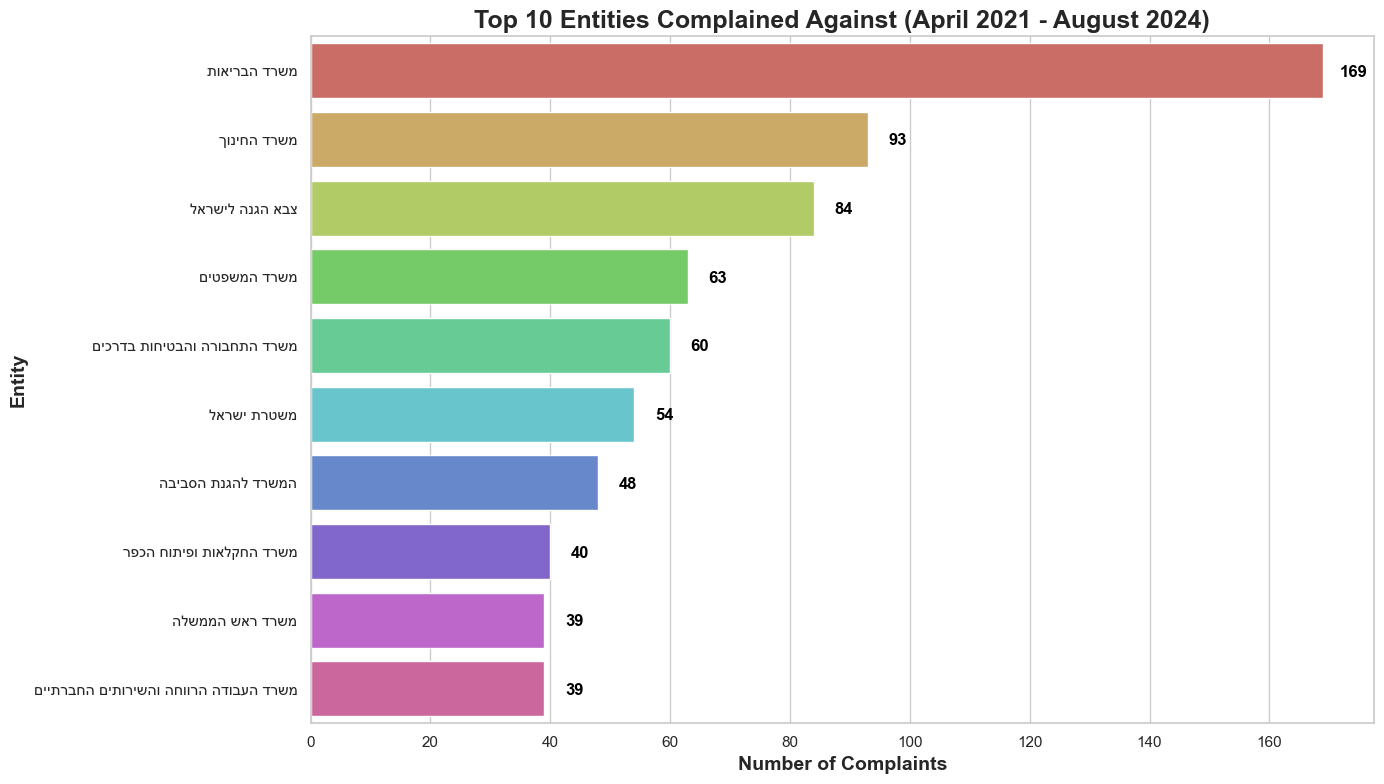

In [88]:
# Top 10 entities that were most frequently complained against

# Enable RTL (Right-to-Left) text support
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Get the top 10 most complained against entities
top_10_entities = df_combined['Entity Complained Against'].value_counts().head(10)

# Set the style to a professional and clean design
sns.set(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 8))

# Plot the data using a barplot
ax = sns.barplot(x=top_10_entities.values, y=top_10_entities.index, 
                 hue=top_10_entities.index, palette='hls', dodge=False, legend=False)

# Reverse the text direction for the y-axis labels (Hebrew)
ax.set_yticks(range(len(top_10_entities)))
ax.set_yticklabels([label[::-1] for label in top_10_entities.index])

# Add title and labels with professional formatting
plt.title('Top 10 Entities Complained Against (April 2021 - August 2024)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Entity', fontsize=14)

# Add the exact number of complaints on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 5, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

This visualization highlights the top 10 entities that have received the most complaints. The Ministry of Health ("משרד הבריאות") stands out significantly, receiving 169 complaints, which is nearly double the number received by the next most-complained-against entity, the Ministry of Education ("משרד החינוך"). Other frequently complained-against entities include the Israel Defense Forces ("צבא הגנה לישראל"), the Ministry of Justice ("משרד המשפטים"), and the Ministry of Transport and Road Safety ("משרד התחבורה והבטיחות בדרכים"). This distribution indicates areas where public dissatisfaction is concentrated, particularly within health, education, and security-related sectors. Understanding the reasons behind these complaints could be key to addressing systemic issues within these entities.

#### Top 5 Entities Complained Against by Year

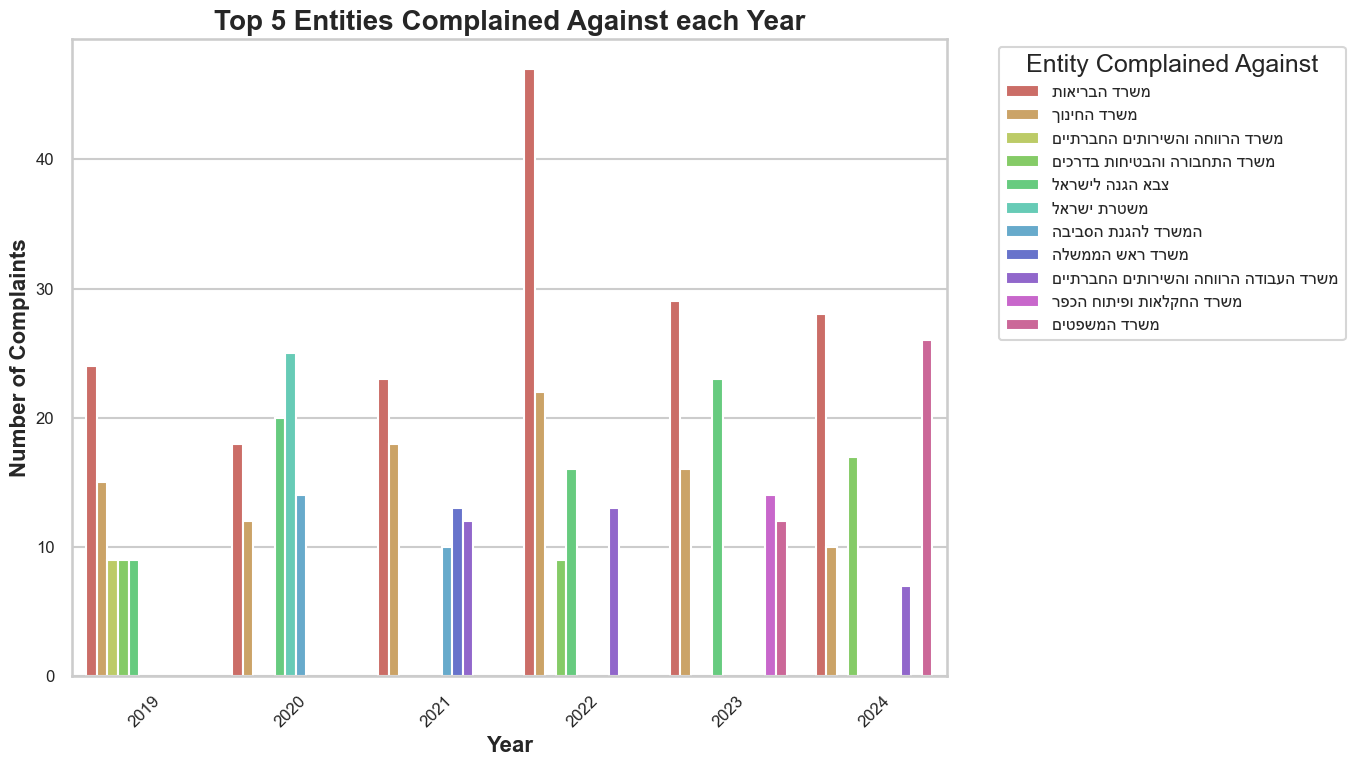

In [110]:
# Top 5 Entities Complained Against by Year

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'  
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Group data by year and entity, and count the number of complaints
complaints_by_entity_year = df_combined.groupby(['Complaint Receipt Year', 'Entity Complained Against']).size().reset_index(name='Complaint Count')

# Sort values to identify top entities each year
complaints_by_entity_year = complaints_by_entity_year.sort_values(['Complaint Receipt Year', 'Complaint Count'], ascending=[True, False])

# For each year, get the top 5 entities (or adjust as needed)
top_entities_each_year = complaints_by_entity_year.groupby('Complaint Receipt Year').head(5)

# Reverse the Hebrew text for correct display in the plot using .loc[]
top_entities_each_year.loc[:, 'Entity Complained Against'] = top_entities_each_year['Entity Complained Against'].apply(lambda x: x[::-1])

# Set up the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Complaint Receipt Year', y='Complaint Count', hue='Entity Complained Against', data=top_entities_each_year, palette='hls')

# Add title and labels with professional formatting
plt.title('Top 5 Entities Complained Against each Year', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)

# Customize legend for better readability
plt.legend(title='Entity Complained Against', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

This visualization shows the distribution of complaints against the top five entities over several years. The Ministry of Health ("משרד הבריאות") consistently receives a high number of complaints each year, peaking in 2021. Other entities such as the Ministry of Education ("משרד החינוך") and the Ministry of Transport and Road Safety ("משרד התחבורה והבטיחות בדרכים") also feature prominently, although their complaint numbers vary more significantly year by year. The trends indicate that certain entities are persistently problematic, potentially reflecting ongoing systemic issues or heightened public scrutiny. The fluctuation in complaints over time might suggest periods of reform or change within these entities, or external factors influencing public perception and interaction.

#### Heatmap of Complaint Subjects for Top Entities

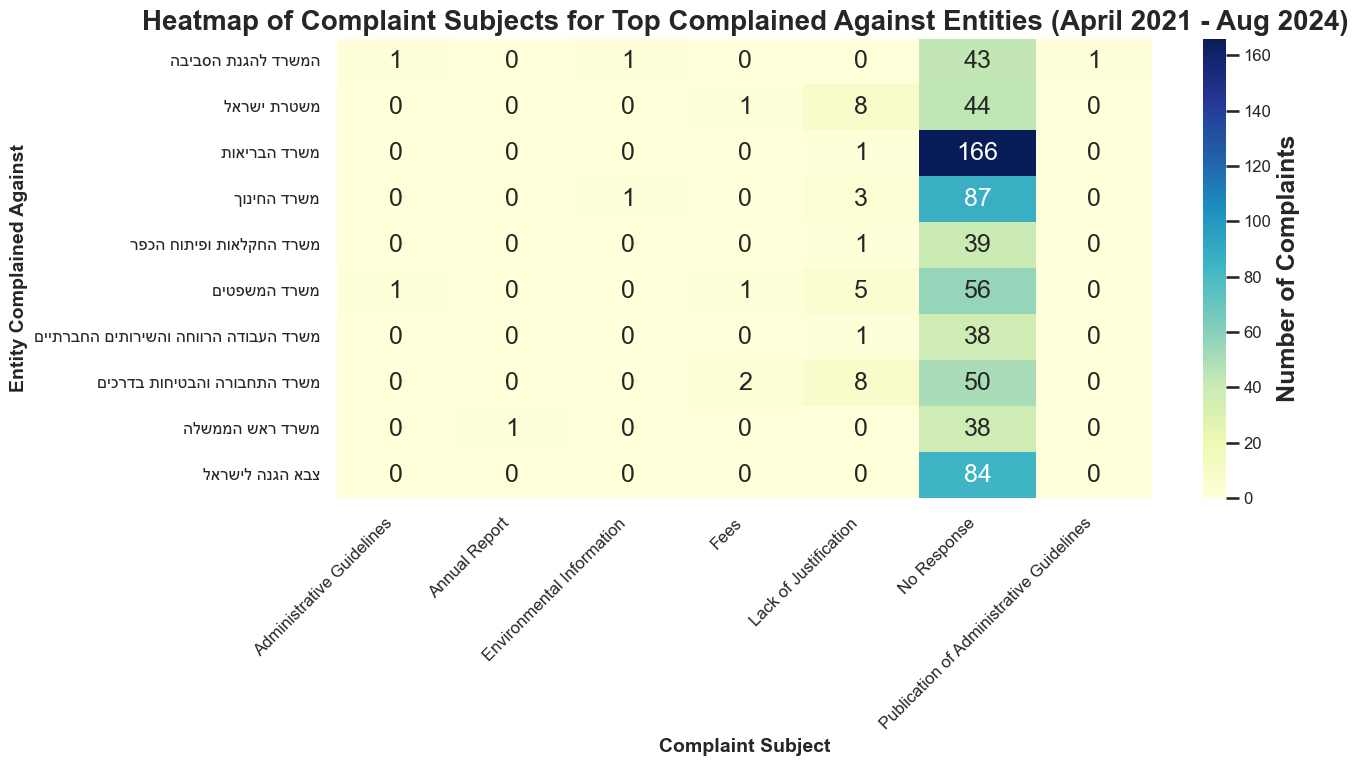

In [134]:
# Heatmap of Complaint Subjects for Top  Complained AgainstEntities

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Identify the Top Entities by Number of Complaints
top_entities = df_combined['Entity Complained Against'].value_counts().head(10).index.tolist()

# Filter the data for only the top entities and exclude 'Unknown'
filtered_df = df_combined[(df_combined['Entity Complained Against'].isin(top_entities)) &
                          (~df_combined['Complaint Subject'].isin(['Unknown']))]

# Create a pivot table for heatmap
heatmap_data = filtered_df.pivot_table(index='Entity Complained Against', 
                                       columns='Complaint Subject', 
                                       aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Complaints'})

# Title and labels
plt.title('Heatmap of Complaint Subjects for Top Complained Against Entities (April 2021 - Aug 2024)', fontsize=20, fontweight='bold')
plt.xlabel('Complaint Subject', fontsize=14)
plt.ylabel('Entity Complained Against', fontsize=14)

# Reverse text for Hebrew on Y-axis and X-axis labels
ax = plt.gca()  # Get the current axis
ax.set_yticklabels([label.get_text()[::-1] for label in ax.get_yticklabels()])

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

This heatmap illustrates the distribution of complaint subjects across the top entities that receive complaints. The "No Response" category dominates across several entities, particularly the Ministry of Health, which alone accounts for 166 complaints in this category. This suggests that failure to respond is a significant issue, especially within the Ministry of Health. Other entities like the Ministry of Education and the Ministry of Transport and Road Safety also show high numbers of complaints under "No Response." The presence of other categories like "Lack of Justification" and "Publication of Administrative Guidelines" is less prominent, indicating that the main grievance among complainants is often related to a lack of response from these entities. This insight highlights the need for these organizations to improve their communication and responsiveness to reduce the volume of complaints.

#### Heatmap of Decision for Top Entities (April 2021 - Aug 2024)

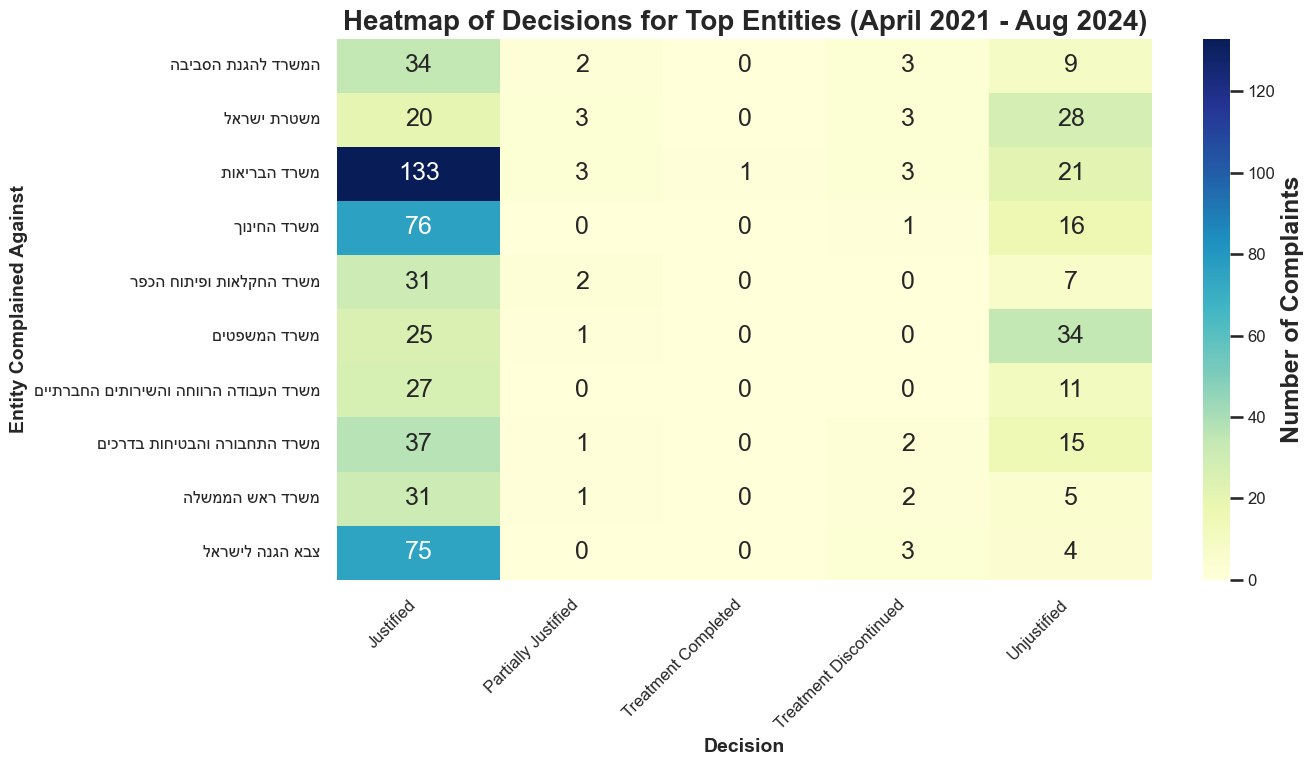

In [112]:
# Heatmap of Decision for Top Entities

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Identify the Top Entities by Number of Complaints
top_entities = df_combined['Entity Complained Against'].value_counts().head(10).index.tolist()

# Filter the data for only the top entities and exclude 'Unknown'
filtered_df = df_combined[(df_combined['Entity Complained Against'].isin(top_entities)) &
                          (~df_combined['Decision'].isin(['Unknown']))]

# Create a pivot table for heatmap
heatmap_data = filtered_df.pivot_table(index='Entity Complained Against', 
                                       columns='Decision', 
                                       aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Complaints'})

# Title and labels
plt.title('Heatmap of Decisions for Top Entities (April 2021 - Aug 2024)', fontsize=20, fontweight='bold')
plt.xlabel('Decision', fontsize=14)
plt.ylabel('Entity Complained Against', fontsize=14)

# Reverse text for Hebrew on Y-axis labels
ax = plt.gca()  # Get the current axis
ax.set_yticklabels([label.get_text()[::-1] for label in ax.get_yticklabels()])

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

This heatmap presents the decisions made for complaints across various top entities. The Ministry of Health stands out with a notably high number of "Justified" complaints, indicating significant validity in the grievances raised against this entity. Other entities such as the Ministry of Education and the Ministry of Transport also show a relatively high count of justified complaints. The "Unjustified" category is less prevalent across most entities, suggesting that the majority of complaints, especially for the Ministry of Health, tend to be well-founded. This insight could suggest a need for these entities to address the root causes of justified complaints to reduce their frequency. Additionally, the distribution of other decisions, such as "Treatment Discontinued" and "Partially Justified," shows varying patterns across entities, with some, like the Ministry of Justice, having a higher proportion of "Unjustified" decisions, which may reflect a different nature of complaints or decision-making processes.

#### Average Time to Decision by Entity

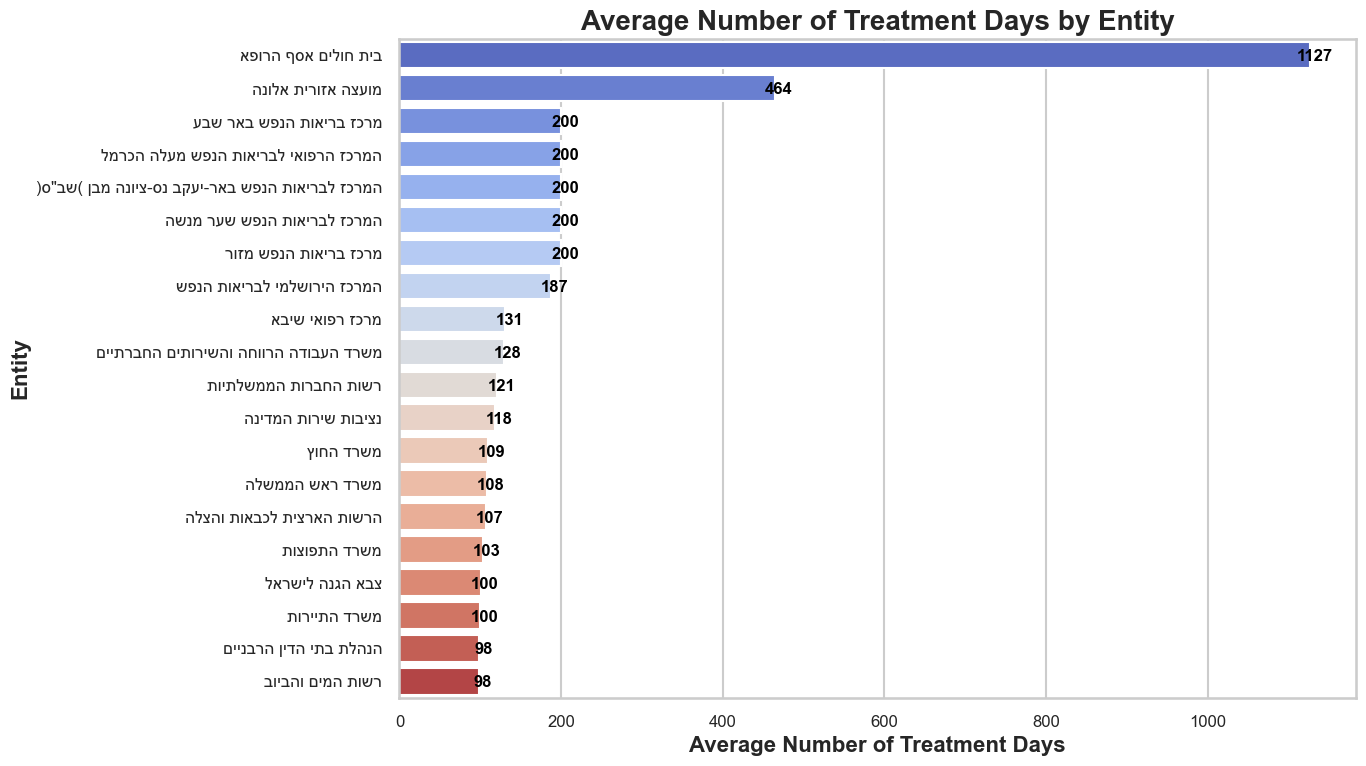

In [113]:
# Average Time to Decision by Entity

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Calculate the average number of treatment days by entity
avg_treatment_entity = df_combined.groupby('Entity Complained Against')['Number of Treatment Days'].mean().sort_values(ascending=False).head(20)

# Plot the average number of treatment days by entity
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=avg_treatment_entity.values, y=avg_treatment_entity.index, palette='coolwarm', legend=False, hue=avg_treatment_entity.index)

# Set y-tick labels with reversed text for Hebrew
ax.set_yticks(range(len(avg_treatment_entity.index)))
ax.set_yticklabels([label[::-1] for label in avg_treatment_entity.index])

# Add the exact number of treatment days on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 5, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

# Add titles and labels
plt.title('Average Number of Treatment Days by Entity', fontsize=20, fontweight='bold')
plt.xlabel('Average Number of Treatment Days', fontsize=16)
plt.ylabel('Entity', fontsize=16)

plt.tight_layout()
plt.show()

This bar chart shows the average number of treatment days by entity, highlighting significant variations in response times across different organizations. Notably, "בית חולים אסף הרופא" (Assaf Harofeh Hospital) stands out with an exceptionally high average of 1127 treatment days, far exceeding any other entity. This suggests potential inefficiencies or complexities in handling complaints at this hospital. The second entity, "מועצה אזורית אלונה" (Alona Regional Council), also shows a high average treatment time of 464 days. Other entities, primarily medical or health-related institutions, also display longer-than-average treatment times. These findings indicate that certain entities, particularly in the healthcare sector, may face systemic challenges in processing complaints efficiently, warranting further investigation and targeted improvements.

#### Average Time to Initial Response by Entity

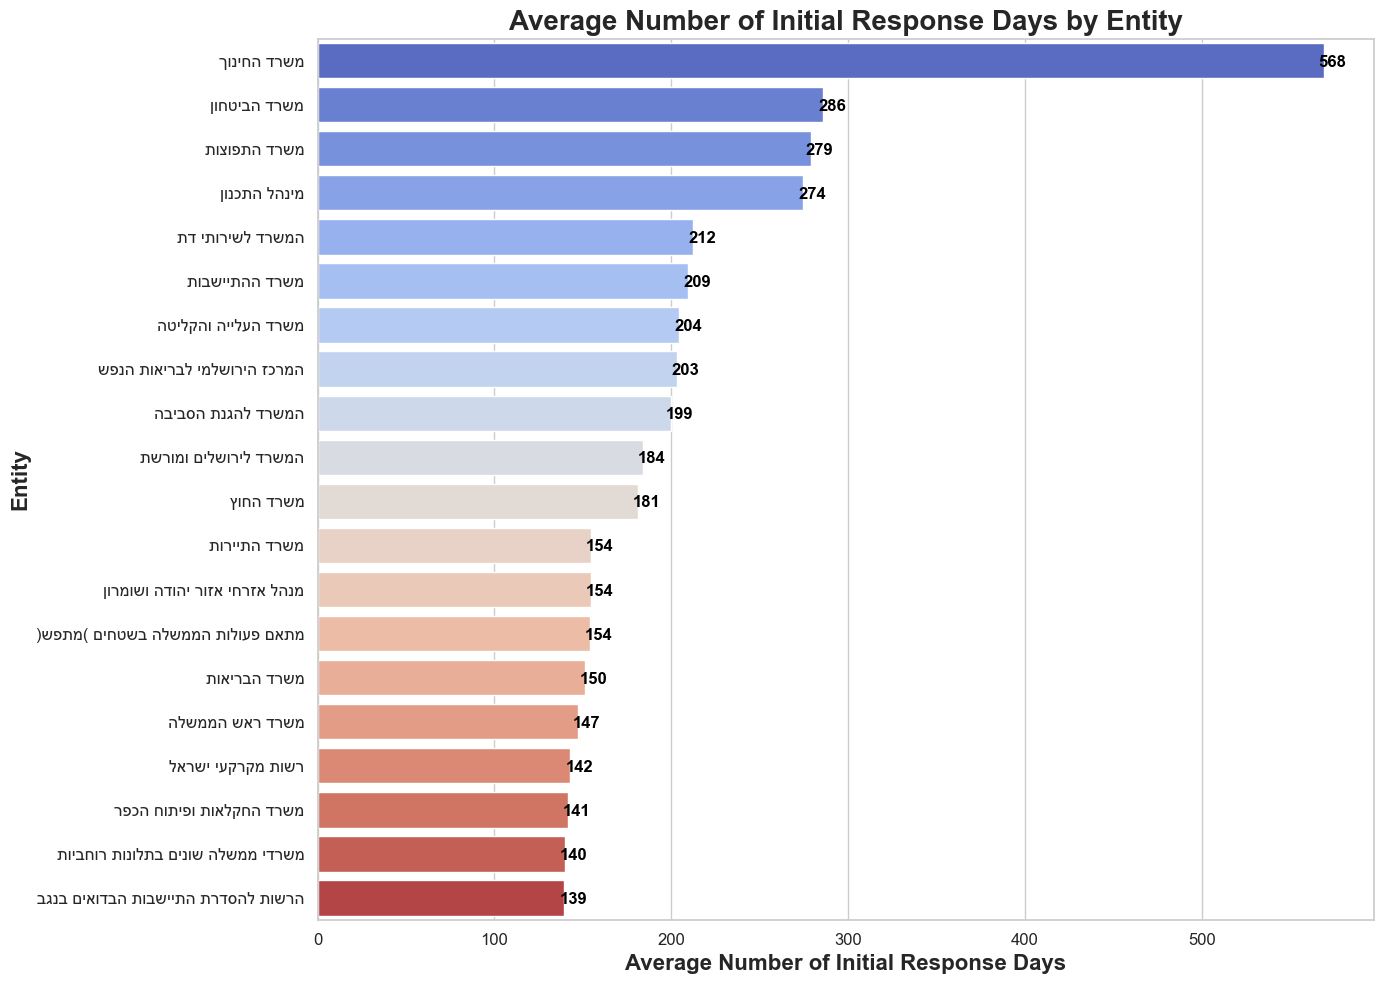

In [93]:
# Average Time to Initial Response by Entity

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Calculate the average number of treatment days by entity
avg_treatment_entity = df_combined.groupby('Entity Complained Against')['Initial Response Days'].mean().sort_values(ascending=False).head(20)

# Plot the average number of treatment days by entity
plt.figure(figsize=(14, 10))
ax = sns.barplot(x=avg_treatment_entity.values, y=avg_treatment_entity.index, palette='coolwarm', legend=False, hue=avg_treatment_entity.index)

# Set y-tick labels with reversed text for Hebrew
ax.set_yticks(range(len(avg_treatment_entity.index)))
ax.set_yticklabels([label[::-1] for label in avg_treatment_entity.index])

# Add the exact number of treatment days on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 5, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

# Add titles and labels
plt.title('Average Number of Initial Response Days by Entity', fontsize=20, fontweight='bold')
plt.xlabel('Average Number of Initial Response Days', fontsize=16)
plt.ylabel('Entity', fontsize=16)

plt.tight_layout()
plt.show()

This bar chart displays the average number of initial response days by entity, revealing substantial delays in the initial handling of complaints by certain organizations. "משרד החינוך" (Ministry of Education) stands out with an exceptionally high average of 568 days to provide an initial response, which is significantly longer than any other entity. Following it, "משרד הביטחון" (Ministry of Defense) and "משרד התפוצות" (Ministry of Diaspora Affairs) also exhibit prolonged response times, with averages of 286 and 279 days, respectively. These extended response times suggest potential challenges or inefficiencies within these entities in addressing complaints promptly, which could impact the public's trust and satisfaction. Addressing these delays could be crucial for improving service quality and responsiveness in these sectors.

#### Success Rate by Entity (Percentage of Justified Complaints)

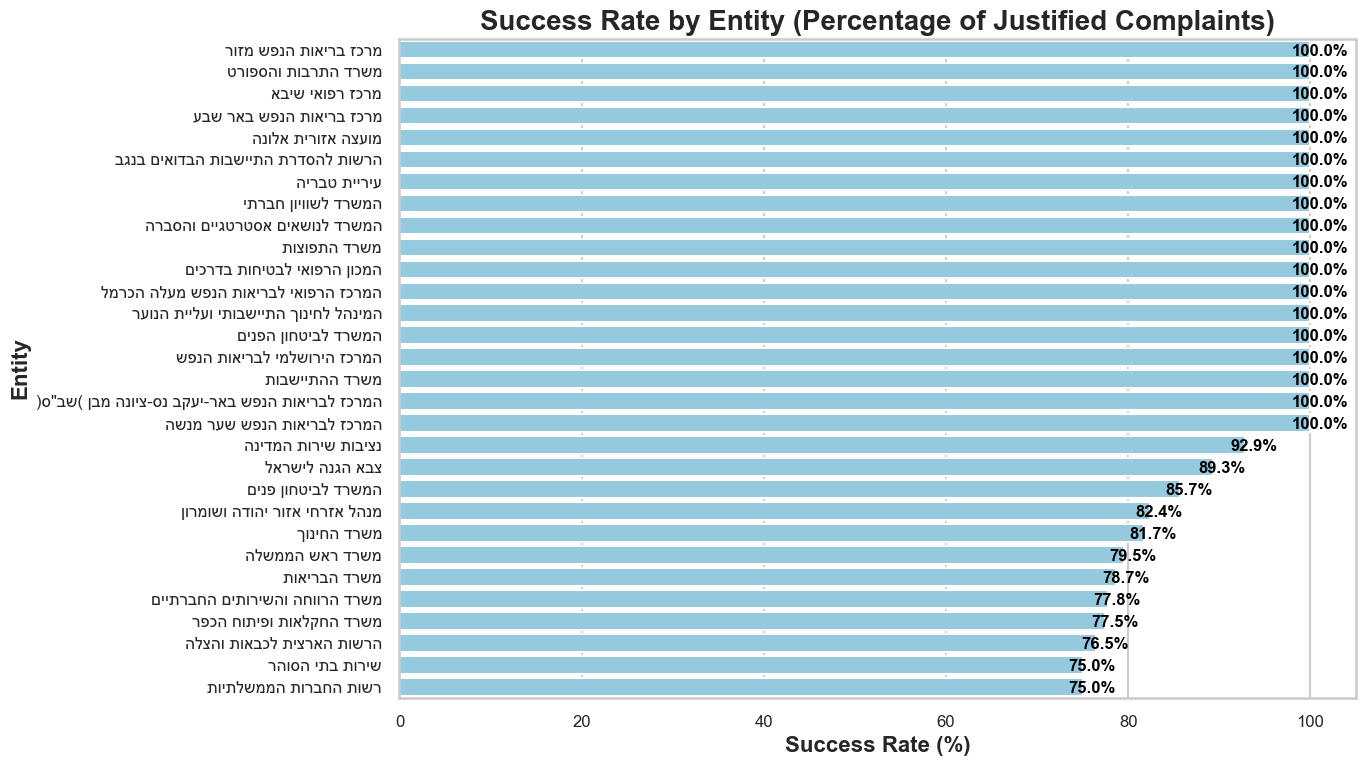

In [116]:
# Success Rate by Entity (Percentage of Justified Complaints)

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Calculate the success rate by entity
success_rate = df_combined[df_combined['Decision'] == 'Justified'].groupby('Entity Complained Against').size() / df_combined.groupby('Entity Complained Against').size() * 100

# Sort success rate for better visualization and limit to top 20 entities
success_rate = success_rate.sort_values(ascending=False).head(30)

# Plot the success rate by entity
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=success_rate.values, y=success_rate.index, color='skyblue', legend=False)

# Set y-tick labels with reversed text for Hebrew
ax.set_yticks(range(len(success_rate)))
ax.set_yticklabels([label[::-1] for label in success_rate.index])

# Add titles and labels
plt.title('Success Rate by Entity (Percentage of Justified Complaints)', fontsize=20, fontweight='bold')
plt.xlabel('Success Rate (%)', fontsize=16)
plt.ylabel('Entity', fontsize=16)

# Add exact success rate on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%', 
                (p.get_width() + 1, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


This bar chart illustrates the success rate by entity, defined as the percentage of justified complaints. The chart highlights that many entities, including several mental health centers, government ministries, and local authorities, have a perfect success rate of 100%. This suggests that all complaints filed against these entities were found to be justified. On the lower end, entities like the "רשות החברות הממשלתיות" (Government Companies Authority) and "שירות בתי הסוהר" (Israel Prison Service) have lower success rates of 75%, indicating a higher proportion of complaints deemed unjustified. This variation in success rates could reflect differences in complaint handling processes, transparency, or the nature of the issues each entity faces. It may also point to areas where certain entities could improve their responsiveness or address systemic issues that lead to justified complaints.

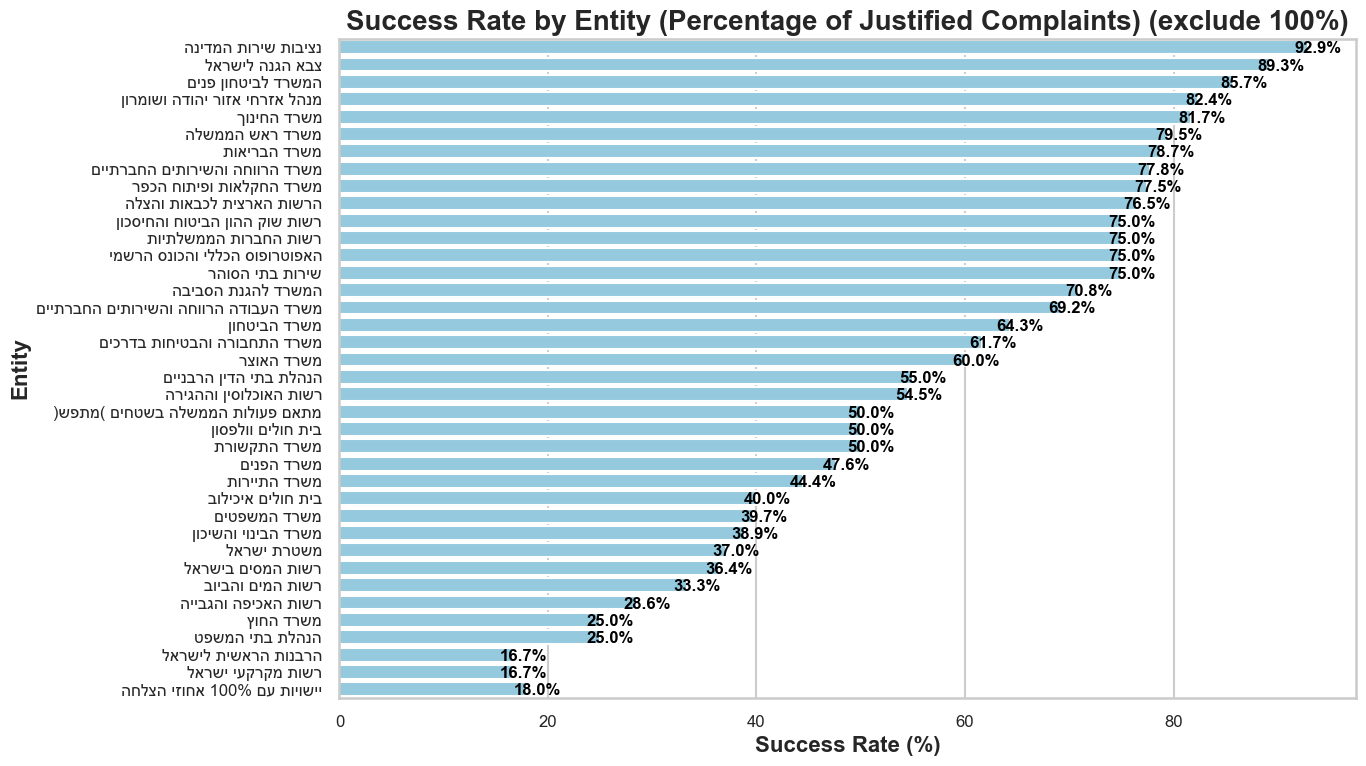

In [115]:
# Success Rate by Entity (Percentage of Justified Complaints) (exclude 100%)

# Ensure proper display of Hebrew text
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Calculate the success rate by entity
success_rate = df_combined[df_combined['Decision'] == 'Justified'].groupby('Entity Complained Against').size() / df_combined.groupby('Entity Complained Against').size() * 100

# Combine all entities with 100% success rate into a single category
combined_success_rate = success_rate[success_rate < 100].sort_values(ascending=False)
combined_success_rate['יישויות עם %001 אחוזי הצלחה'] = len(success_rate[success_rate == 100])

# Plot the success rate by entity
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=combined_success_rate.values, y=combined_success_rate.index, color='skyblue')

# Set y-tick labels with reversed text for Hebrew
ax.set_yticks(range(len(combined_success_rate)))
ax.set_yticklabels([label[::-1] for label in combined_success_rate.index])

# Add titles and labels
plt.title('Success Rate by Entity (Percentage of Justified Complaints) (exclude 100%)', fontsize=20, fontweight='bold')
plt.xlabel('Success Rate (%)', fontsize=16)
plt.ylabel('Entity', fontsize=16)

# Add exact success rate on each bar
for p in ax.patches:
    if p.get_width() > 1:  # For all bars except the combined category
        ax.annotate(f'{p.get_width():.1f}%', 
                    (p.get_width() + 1, p.get_y() + p.get_height() / 2), 
                    ha='center', va='center_baseline', 
                    fontsize=12, color='black', fontweight='bold')
    else:  # For the combined category
        ax.annotate(f'{int(p.get_width())} Entities', 
                    (p.get_width() + 1, p.get_y() + p.get_height() / 2), 
                    ha='center', va='center_baseline', 
                    fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

This bar chart displays the success rates for entities with justified complaints, excluding those with a 100% success rate. The chart reveals a wide range of success rates, with entities like "נציבות שירות המדינה" (Civil Service Commission) and "צבא הגנה לישראל" (IDF) having relatively high success rates of over 80%, while entities such as "רשות המים והביוב" (Water and Sewage Authority) and "הרשות לאכיפה והגירה" (Enforcement and Immigration Authority) have much lower success rates, as low as 16.7%. This variation highlights disparities in how different entities handle complaints, with some consistently justifying complaints while others appear to have significant room for improvement. The lower success rates might indicate issues in transparency, responsiveness, or the nature of complaints that these entities face, warranting further investigation to identify underlying causes and areas for potential improvement.

### Complainant Type Viz

#### Distribution of Complaints by Complainant Type
Note: Complainant Type is only relevant for the df_pre_2021_april meaning post april 2021

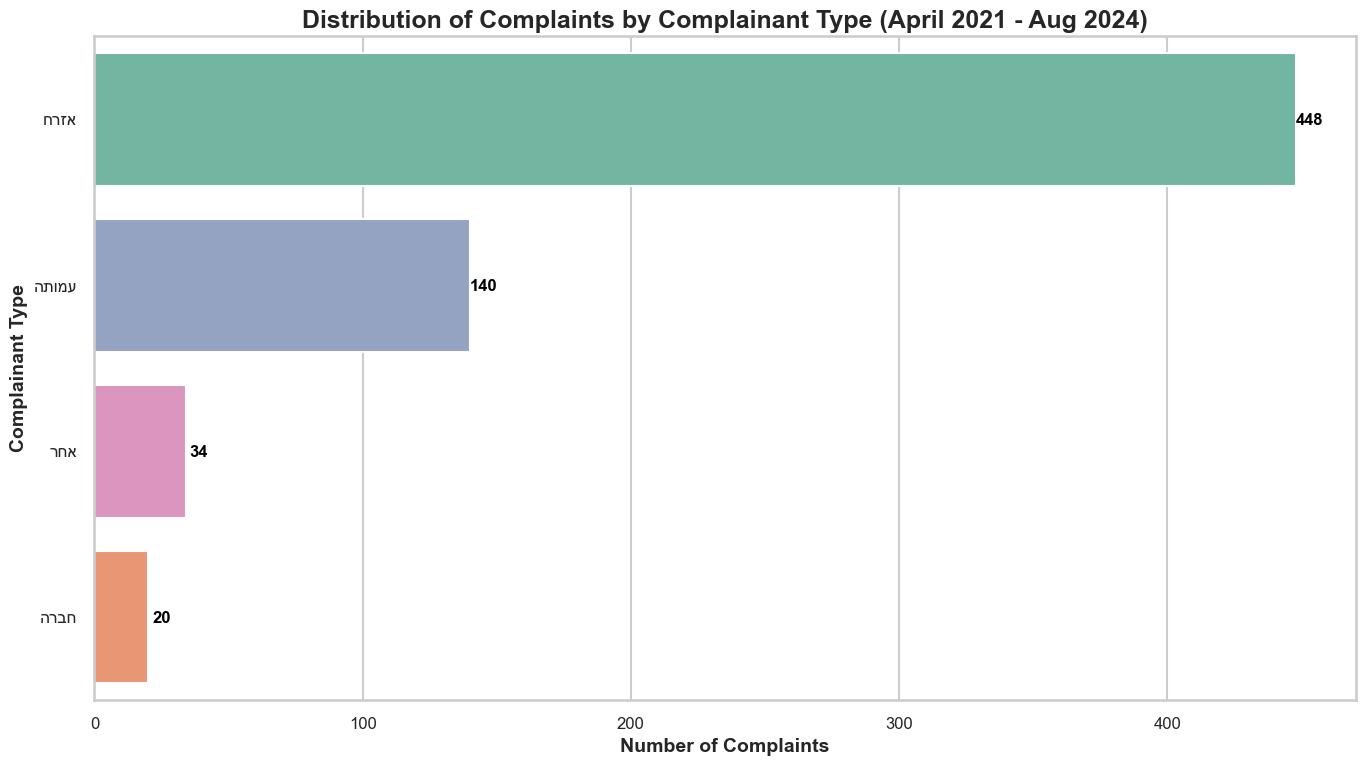

In [132]:
# Distribution of Complaints by Complainant Type

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Filter out rows where 'Complainant Type' is 'Unspecified'
df_filtered = df_combined[df_combined['Complainant Type'] != 'Unspecified']

# Plot the distribution of complaints by complainant type
plt.figure(figsize=(14, 8))
ax = sns.countplot(y='Complainant Type', data=df_filtered, 
                   order=df_filtered['Complainant Type'].value_counts().index, 
                   palette='Set2', hue='Complainant Type', legend=False)

# Set y-tick labels with reversed text for Hebrew
ax.set_yticks(range(len(ax.get_yticklabels())))
ax.set_yticklabels([label.get_text()[::-1] for label in ax.get_yticklabels()])

# Add titles and labels
plt.title('Distribution of Complaints by Complainant Type (April 2021 - Aug 2024)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Complainant Type', fontsize=14)

# Add exact number of complaints on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 5, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


This bar chart shows the distribution of complaints by different types of complainants. The majority of complaints come from individuals ("אזרח") with 448 complaints, followed by non-profit organizations ("עמותה") with 140 complaints. Businesses ("חברה") and other entities ("אחר") contribute significantly fewer complaints, with 20 and 34 respectively. This distribution suggests that individual citizens are the most active in lodging complaints, which may reflect their direct experiences with the entities in question. The significant presence of non-profit organizations indicates their role in advocacy and representing collective interests in filing complaints.

#### Average Number of Treatment Days by Complainant Type
Note: Complainant Type is only relevant for the df_pre_2021_april meaning post april 2021

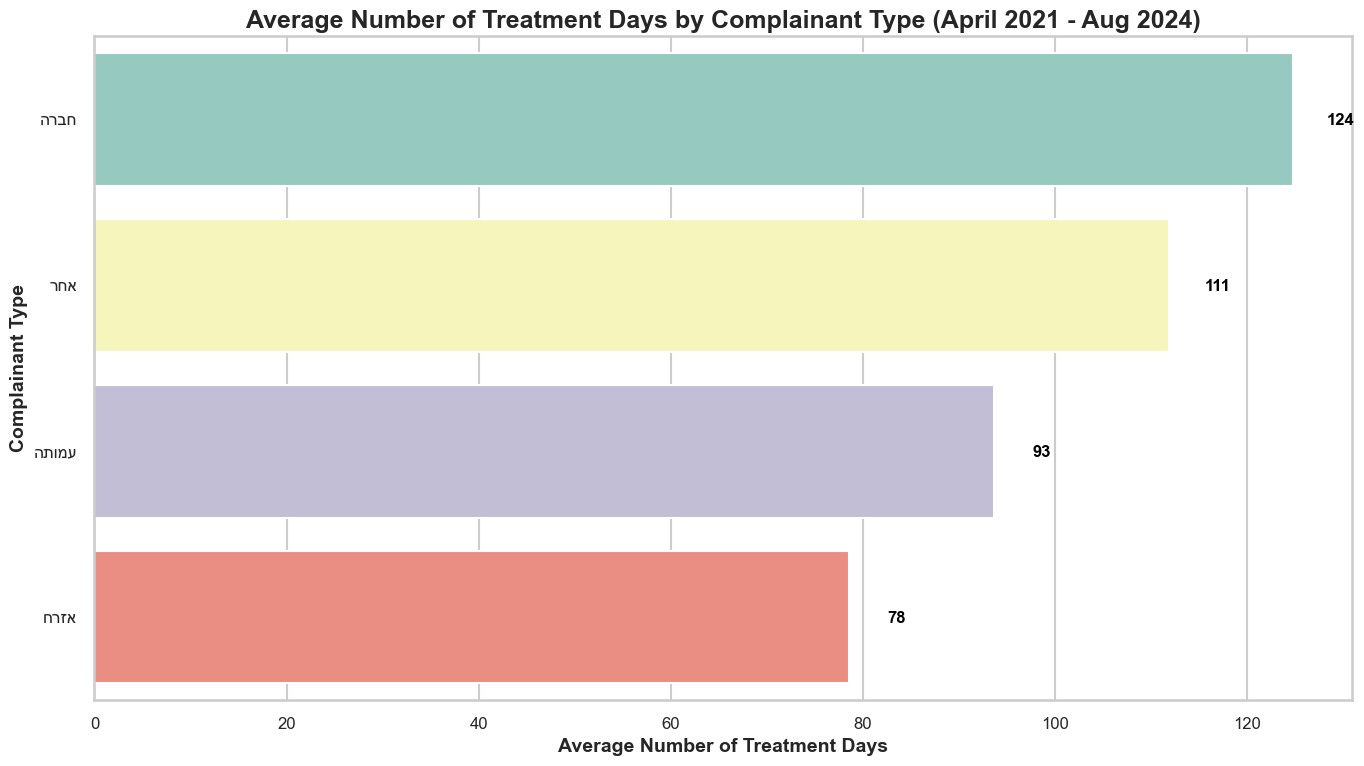

In [131]:
# Average Number of Treatment Days by Complainant Type

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Filter out rows where 'Complainant Type' is 'Unspecified'
df_filtered = df_combined[df_combined['Complainant Type'] != 'Unspecified']

# Calculate the average number of treatment days by complainant type
avg_treatment_complainant_type = df_filtered.groupby('Complainant Type')['Number of Treatment Days'].mean().sort_values(ascending=False)

# Plot the average number of treatment days by complainant type
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=avg_treatment_complainant_type.values, y=avg_treatment_complainant_type.index, hue=avg_treatment_complainant_type.index, palette='Set3', legend=False)

# Set y-tick labels with reversed text for Hebrew
ax.set_yticks(range(len(ax.get_yticklabels())))
ax.set_yticklabels([label.get_text()[::-1] for label in ax.get_yticklabels()])

# Add titles and labels
plt.title('Average Number of Treatment Days by Complainant Type (April 2021 - Aug 2024)', fontsize=18, fontweight='bold')
plt.xlabel('Average Number of Treatment Days', fontsize=14)
plt.ylabel('Complainant Type', fontsize=14)

# Add exact average days on each bar
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 5, p.get_y() + p.get_height() / 2), 
                ha='center', va='center_baseline', 
                fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


This bar chart illustrates the average number of treatment days by complainant type. The data reveals that complaints lodged by businesses ("חברה") take the longest to resolve, with an average of 124 treatment days. Following that, complaints filed under "Other" ("אחר") have an average treatment time of 111 days, while non-profit organizations ("עמותה") have a lower average of 93 days. Individual citizens ("אזרח") experience the shortest treatment time, averaging 78 days. These differences suggest that the nature of the complainant type might influence the complexity and the processing time required to resolve the complaints, with businesses potentially dealing with more complex issues or requiring more bureaucratic processes.

#### Distribution of Complaint Subjects by Complainant Type
Note: Complainant Type is only relevant for the df_post_2021_april meaning post april 2021

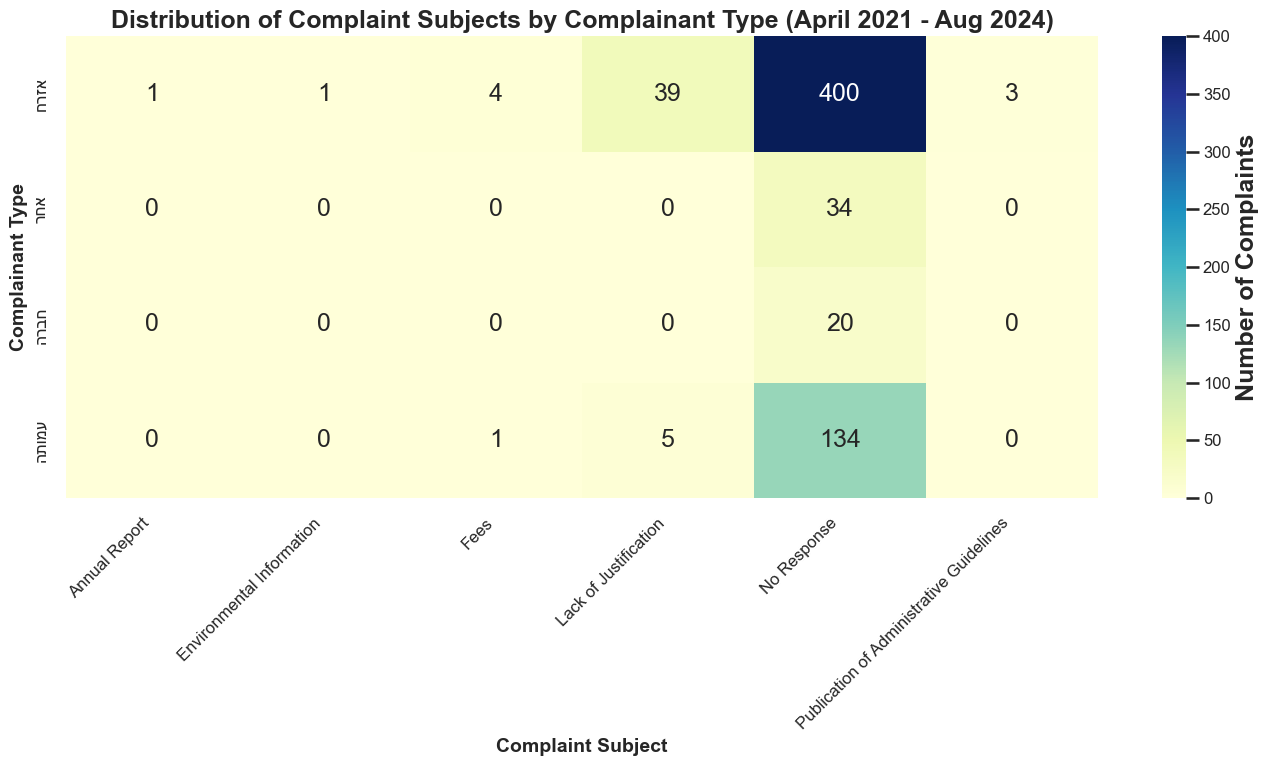

In [130]:
# Distribution of Complaint Subjects by Complainant Type

# Ensure proper display of Hebrew text
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Exclude 'Unknown' Complaint Subject for clarity and Filter out rows where 'Complainant Type' is 'Unspecified'
filtered_df = df_combined[(df_combined['Complaint Subject'] != 'Unknown') & (df_combined['Complainant Type'] != 'Unspecified')]

# Create a crosstab to see the distribution of complaint subjects by complainant type
complaint_subjects_by_type = pd.crosstab(filtered_df['Complainant Type'], filtered_df['Complaint Subject'])

# Plot the distribution using a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(complaint_subjects_by_type, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={'label': 'Number of Complaints'})

# Reverse text for Hebrew on Y-axis labels
ax = plt.gca()  # Get the current axis
ax.set_yticklabels([label.get_text()[::-1] for label in ax.get_yticklabels()])

# Add titles and labels
plt.title('Distribution of Complaint Subjects by Complainant Type (April 2021 - Aug 2024)', fontsize=18, fontweight='bold')
plt.xlabel('Complaint Subject', fontsize=14)
plt.ylabel('Complainant Type', fontsize=14)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


This heatmap shows the distribution of complaint subjects by complainant type, highlighting significant patterns. The most prominent observation is that individual citizens ("אזרח") overwhelmingly complain about "No Response," with 400 complaints, indicating a major issue with entities not responding to requests from the public. Non-profit organizations ("עמותה") also frequently report "No Response," with 134 complaints, but they also show concern for "Lack of Justification." Businesses ("חברה") and other entities ("אחר") have relatively fewer complaints, with businesses showing a particular focus on "No Response" as well. This distribution suggests that "No Response" is a prevalent issue across different types of complainants, but particularly severe for individuals and non-profits.

### Correlations Viz

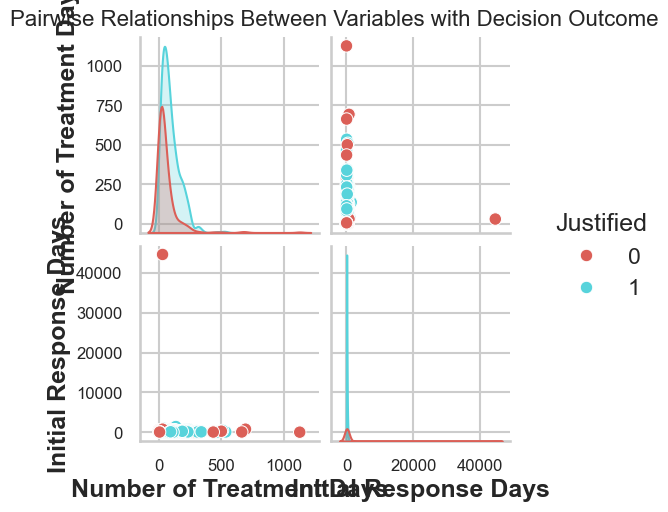

In [129]:
# Pairwise Relationships Between Variables with Decision Outcome

# Selecting relevant columns for pairplot
pairplot_columns = ['Number of Treatment Days', 'Initial Response Days', 'Justified']


# Plot pairwise relationships with hue based on the 'Justified' column
sns.pairplot(df_combined[pairplot_columns], hue='Justified', palette='hls', diag_kind='kde')

plt.suptitle('Pairwise Relationships Between Variables with Decision Outcome', fontsize=16, y=1.02)

plt.show()

This visualization represents pairwise relationships between the variables "Number of Treatment Days," "Initial Response Days," and the "Justified" decision outcome using a scatterplot matrix (pairplot).

Distribution of Variables:
    Number of Treatment Days: Most data points cluster near the lower end, indicating that the majority of complaints are resolved within a shorter time frame. However, there are a few outliers with a very high number of treatment days, as shown by the long tail in the distribution.
    Initial Response Days: Similar to the "Number of Treatment Days," most data points cluster at the lower end, with a few extreme outliers that stand out.

Extreme Outliers:
    The presence of extreme outliers, particularly in the "Initial Response Days" variable, indicates potential issues with data quality, such as data entry errors or genuinely extraordinary cases. These outliers might need further investigation.

General Insights:
    There doesn’t appear to be a strong, linear relationship between either "Number of Treatment Days" or "Initial Response Days" with the decision outcome being justified or not.
    The data is highly skewed, with most values concentrated at the lower end for both "Number of Treatment Days" and "Initial Response Days."

In [98]:
### Understand the combined effect of the variables on the decision outcome using logistic regression model



# Proceed with the logistic regression preparation
df_logistic = df_combined[['Number of Treatment Days', 'Initial Response Days', 'Justified']].dropna()

# Define the independent variables (X) and the dependent variable (y)
X = df_logistic[['Number of Treatment Days', 'Initial Response Days']]
y = df_logistic['Justified']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the summary of the logistic regression model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.619369
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Justified   No. Observations:                 1085
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            2
Date:                Wed, 14 Aug 2024   Pseudo R-squ.:                 0.04273
Time:                        13:31:26   Log-Likelihood:                -672.02
converged:                       True   LL-Null:                       -702.01
Covariance Type:            nonrobust   LLR p-value:                 9.372e-14
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0907      0.097      0.935      0.350      -0.099

##### Remarx on Interpret the Logistic Regression Results

Log-Likelihood and Pseudo R-squared:

The Log-Likelihood value (-672.36) and Pseudo R-squared (0.04333) suggest that the model has a moderate fit, but there may be room for improvement.

Coefficients (coef):

Number of Treatment Days has a positive coefficient (0.0077) and is statistically significant (p < 0.001). This indicates that as the number of treatment days increases, the likelihood of a complaint being justified also increases, although the effect size is relatively small.
Initial Response Days has a near-zero coefficient (-6.367e-05) and is not statistically significant (p = 0.455), suggesting it has little to no effect on whether a complaint is justified.
Complaint Receipt Month also shows a near-zero effect (0.0043) and is not statistically significant (p = 0.821), indicating that the month in which a complaint is received does not significantly influence the outcome.

P-values:

Number of Treatment Days has a p-value < 0.001, making it a significant predictor.
Both Initial Response Days and Complaint Receipt Month have p-values > 0.05, indicating they are not significant predictors in this model.

Thanks for reaching this far. 